In [1]:
# useful to autoreload the module without restarting the kernel
%load_ext autoreload
%autoreload 2

In [2]:
from mppi import InputFiles as I, Calculators as C, Datasets as D, Utilities as U, Parsers as P
from mppi.Utilities import Constants as Const
from mppi.Models import GaussianPulse as G
from mppi.Calculators import Tools
from mppi.Datasets import PostProcessing as PP
import matplotlib.pyplot as plt
import numpy as np
import os

h_red = Const.Planck_reduced_ev_fs
h = Const.Planck_ev_fs
light_speed = Const.Light_speed_nm_fsm1

In [3]:
# RunRules for local computations
mpi = 4
omp = 2

rr = C.RunRules(omp_num_threads=omp,mpi=mpi)
code = C.YamboCalculator(rr)
#code.global_options()

Initialize a Yambo calculator with scheduler direct


In [3]:
# RunRules for ismhpc
# The product of ntasks_per_node*cpus_per_task is equal to 32. 
# Many mpi are needed for better performances
nodes = 2
ntasks_per_node = 32 #16
cpus_per_task = 1 #2
omp_num_threads = 1 #2

ntasks = nodes*ntasks_per_node

rr = C.RunRules(scheduler='slurm',partition='all12h', #'all12h',
                memory='125000',
                nodes=nodes,ntasks_per_node=ntasks_per_node,
                cpus_per_task=cpus_per_task,
                omp_num_threads=omp_num_threads)
code = C.YamboCalculator(rr,executable='yambo_rt',activate_BeeOND=True) #,reformat=False,clean_restart=False,skip=False,fatlog=True)
code.global_options()

Initialize a Yambo calculator with scheduler slurm


{'scheduler': 'slurm',
 'nodes': 2,
 'ntasks_per_node': 32,
 'cpus_per_task': 1,
 'omp_num_threads': 1,
 'gpus_per_node': None,
 'memory': '125000',
 'time': None,
 'partition': 'all12h',
 'account': None,
 'qos': None,
 'map_by': None,
 'pe': 1,
 'rank_by': None,
 'executable': 'yambo_rt',
 'skip': True,
 'clean_restart': True,
 'dry_run': False,
 'wait_end_run': True,
 'activate_BeeOND': True,
 'verbose': True,
 'fatlog': False}

# Analysis of the NEQ dynamics

We study the non-equilibrium dynamics of the system

## Removal of the symmetries broken by the pulse

We perform the FixSymm procedure and remove the symmetries broken by a pulse with 
linear polarization along the $x$ axis. 

We build the run_dir associated to all the $k$-samplings considered in the EQ analysis

In [8]:
run_path = 'NEQ_RT'
kpoints = ['12x12x3']

In [9]:
for k in kpoints: 
    input_dir = 'DFT_analysis/kpoints_12x12x3-nbnds_100.save'
    run_dir = os.path.join(run_path,k)
    rt_run_dir = os.path.join(run_dir,'FixSymm')

    Tools.init_yambo_dir(yambo_dir=run_dir,input_dir=input_dir)
    if not os.path.isdir(rt_run_dir):    
        fixSymm_inp = Tools.build_FixSymm_input(run_dir,polarization='linear')
        ypp_code = C.YamboCalculator(C.RunRules(),executable='ypp')
        ypp_code.run(input=fixSymm_inp,name='FixSymm',run_dir=run_dir)
        Tools.build_r_setup(yambo_dir=rt_run_dir)

Executing command: cd NEQ_RT/12x12x3; p2y -I ../../DFT_analysis/kpoints_12x12x3-nbnds_100.save


## Analysis of the pump pulse

We set the pulse field and we show its Fourier transform together with the (IP) absorption.

The pulse is set to a wavelenght of 800 nm that corresponds to 1.55 eV and has a fwhm of 35 fs.

In [7]:
l = 800 # nm
light_speed*h/l

1.5498024800687957

In [8]:
time_range = 1000 # fs
time = np.linspace(0,time_range,5*(time_range+1))
pulse_energy = 1.55 # eV
fwhm = 35 # fs

In [9]:
pulse = G.gaussianPulse(time,energy=pulse_energy,fwhm=fwhm)

time unit: fs - energy unit: eV
period of the oscillations 2.66817270789182 fs
width of the pulse 14.863131505040334 fs
fwhm of the pulse 35 fs


(0.0, 200.0)

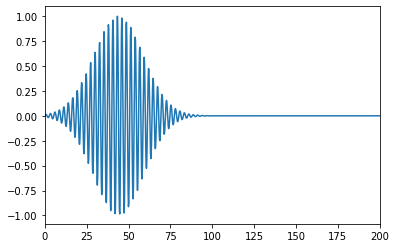

In [10]:
plt.plot(time,pulse)
plt.xlim(0,200)

In [11]:
pulse_freq,pulse_ft = G.evalPulseFourierTransform(time,pulse)

time unit: fs - energy unit: eV
energy resolution of the FT: 0.004134841388768031 eV
maximum energy: 10.341238313308846 eV
FWHM of the FT of the pulse: 0.09923619333043288 eV


In [14]:
alpha_exp= 'Experiment/alpha.dat'
data = np.loadtxt(alpha_exp,delimiter=',').T
energy_alpha,alpha_exp = data

abs_file = 'EQ_ABS/12x12x3/bse-bsengblk_50-bsebands_43-62-kpoints_12x12x3/o-bse-bsengblk_50-bsebands_43-62-kpoints_12x12x3.eps_q1_haydock_bse'
data = P.YamboOutputParser.from_file(abs_file)['eps_q1_haydock_bse']
energy = data['energy']
eps_im = data['eps_imag']
eps_o_im = data['eps_o_imag']
alpha = eps_im*energy
alpha_o = eps_o_im*energy

Parse file EQ_ABS/12x12x3/bse-bsengblk_50-bsebands_43-62-kpoints_12x12x3/o-bse-bsengblk_50-bsebands_43-62-kpoints_12x12x3.eps_q1_haydock_bse


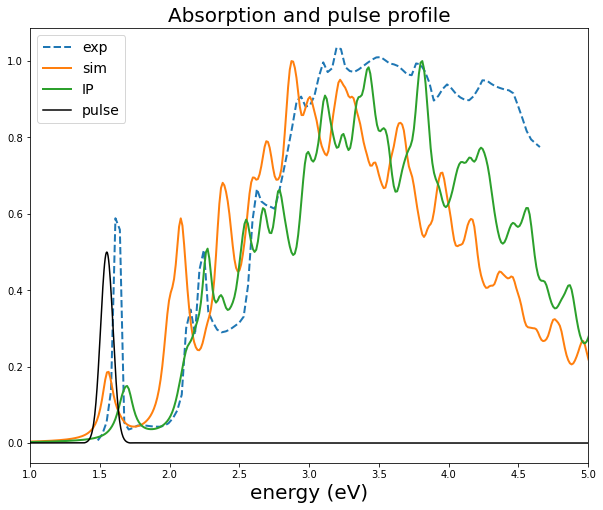

In [16]:
fig, ax = plt.subplots(figsize=(10, 8))

ax.plot(energy_alpha,alpha_exp,label='exp',linestyle='--',linewidth=2)
ax.plot(energy,alpha/max(alpha),label='sim',linewidth=2) 
ax.plot(energy,alpha_o/max(alpha_o),label='IP',linewidth=2) 
ax.plot(pulse_freq,pulse_ft/max(2*pulse_ft),c='black',label='pulse')
ax.set_xlim(1,5)
#ax.set_ylabel(r'$\alpha$',size=20)
ax.set_xlabel('energy (eV)',size=20)
ax.set_title('Absorption and pulse profile',size=20)
ax.legend(fontsize=14)

## NEQ Analysis

We study the time evolution of the carriers.

We select a $k$-samplings

In [4]:
run_path = 'NEQ_RT'
k = '12x12x3'

In [5]:
run_dir = os.path.join(run_path,k,'FixSymm')
run_dir

'NEQ_RT/12x12x3/FixSymm'

The ems1s database has to be computed ex novo due to the FixSymm procedure.

In [86]:
ntasks_c = 16
ntasks_v = int(ntasks/ntasks_c)
print(ntasks_c,ntasks_v)

NGsBlkXs = 200 # (RL) G size of the response function
NGsBlkXs_units = 'RL'
BndsRnXs = [1,100] # Polarization function bands
elec_field = [1.,0.,0.]

study = D.Dataset(num_tasks=1,verbose=True)
study.set_postprocessing_function(PP.yambo_parse_data)

inp = I.YamboInput('yambo -X s',folder=run_dir)
inp.set_array_variables(units=NGsBlkXs_units,NGsBlkXs=NGsBlkXs)
inp.set_array_variables(BndsRnXs=BndsRnXs,LongDrXs=elec_field)
inp.set_scalar_variables(SE_ROLEs='q.qp.b',SE_CPU='1.1.32') # for 1 nodes on ismhpc (with 32 mpi and 1 omp per node)
#inp.set_scalar_variables(X_and_IO_ROLEs='q.g.k.c.v',X_and_IO_CPU='1.1.4.4.2') # for 1 node on ismhpc (with 32 mpi and 1 omp per node)
inp.set_scalar_variables(X_and_IO_ROLEs='q.g.k.c.v',X_and_IO_CPU='1.1.1.%s.%s'%(ntasks_c,ntasks_v))
idd = 'em1s-ngsblkxs_%s-bndsrnxs_%s'%(NGsBlkXs,BndsRnXs[1])
study.append_run(id=idd,input=inp,runner=code,run_dir=run_dir)

16 2
Initialize a Dataset with 1 parallel tasks


In [87]:
study.runs[0]

{'label': 'Dataset',
 'run_dir': 'NEQ_RT/12x12x3/FixSymm',
 'num_tasks': 1,
 'verbose': True,
 'input': {'args': 'yambo -X s',
  'folder': 'NEQ_RT/12x12x3/FixSymm',
  'filename': 'yambo.in',
  'arguments': ['em1s'],
  'variables': {'DIP_Threads': [0.0, ''],
   'X_Threads': [0.0, ''],
   'NGsBlkXs': [200, 'RL'],
   'Chimod': 'HARTREE',
   'XTermKind': 'none',
   'BndsRnXs': [[1, 100], ''],
   'LongDrXs': [[1.0, 0.0, 0.0], ''],
   'SE_ROLEs': 'q.qp.b',
   'SE_CPU': '1.1.32',
   'X_and_IO_ROLEs': 'q.g.k.c.v',
   'X_and_IO_CPU': '1.1.1.16.2'}},
 'name': 'em1s-ngsblkxs_200-bndsrnxs_100'}

In [88]:
results = study.run()

Run the selection [0] with the parallel task_groups [[0]] 

Run the task [0] 
run command: mpirun -np 32 yambo_rt -F em1s-ngsblkxs_200-bndsrnxs_100.in -J em1s-ngsblkxs_200-bndsrnxs_100 -C em1s-ngsblkxs_200-bndsrnxs_100
slurm submit:  cd NEQ_RT/12x12x3/FixSymm ; sbatch job_em1s-ngsblkxs_200-bndsrnxs_100.sh
computation em1s-ngsblkxs_200-bndsrnxs_100 is running...
computation em1s-ngsblkxs_200-bndsrnxs_100 ended

        There are no o-* files.
        Maybe you have performed a computation that does not create any output file or wait_end_run
        and/or the dry_run option are active.
        Otherwise a possible error has occured during the computation
        
Run performed in 19m-33s
Task [0] ended 
 


Now we peform a RT simulation

In [9]:
n_tasks = ntasks_per_node*nodes

field_int = 1e7 # intensity of the pulses in kW/cm^2
field_int_str = '1e7'
fwhm = 35 # fs 
energy = 1.55 # eV
time_step = 10 # as
sim_time = 150 # fs
bands = [49,56] #[49,54] #[51,56] #  
scissor = 0.261
eta = 0.05 # eV
io_time = [10.0,10.0,1.]  # I/O (CARRIERs - GF - OUTPUT) in fs 
io_cache_time = [1.,10.] # Time between two consecutive (caching - I/O) of OBSERVABLES in fs

study = D.Dataset(run_dir=run_dir,num_tasks=1,verbose=True,skip=True)
study.set_postprocessing_function(PP.yambo_parse_data)

inp = I.YamboInput('yambo_rt -n p -v ip -V rt',folder=run_dir)
inp.set_rt_bands(bands=bands,scissor=scissor,damping_valence=eta,damping_conduction=eta)
inp.set_rt_simulationTimes(sim_time=sim_time,io_time=io_time,io_cache_time=io_cache_time,time_step=time_step)
inp.set_rt_cpu(ntasks)
#inp.set_scalar_variables(DBsIOoff='obs GF CARRIERs') # do not write these ndbs on disk
inp.set_rt_field(int=field_int,fwhm=fwhm,polarization='linear',freq=energy)
idd = 'ip_field-int_%s-energy_%s-bands_%s-%s'%(field_int_str,energy,bands[0],bands[1])
study.append_run(id=idd,input=inp,runner=code)

inp = I.YamboInput('yambo_rt -n p -v hsex -e -V rt',folder=run_dir)
inp.set_rt_bands(bands=bands,scissor=scissor,damping_valence=eta,damping_conduction=eta)
inp.set_rt_simulationTimes(sim_time=sim_time,io_time=io_time,io_cache_time=io_cache_time,time_step=time_step)
inp.set_rt_cpu(k=16,b=4) # 2 nodes - 64 mpi
inp.set_array_variables(COLLBands=bands)
inp.set_scalar_variables(HXC_Potential='SEX+HARTREE')
inp.set_rt_field(int=field_int,fwhm=fwhm,polarization='linear',freq=energy)
idd = 'sex_field-int_%s-energy_%s-bands_%s-%s'%(field_int_str,energy,bands[0],bands[1])
study.append_run(id=idd,input=inp,runner=code,jobname=[idd,'em1s-ngsblkxs_200-bndsrnxs_100'])

Initialize a Dataset with 1 parallel tasks


In [10]:
#study.runs[1]

In [11]:
results = study.run()

Run the selection [0, 1] with the parallel task_groups [[0], [1]] 

Run the task [0] 
Skip the run of ip_field-int_1e7-energy_1.55-bands_49-56
Task [0] ended 
 
Run the task [1] 
Skip the run of sex_field-int_1e7-energy_1.55-bands_49-56
Task [1] ended 
 


Text(0, 0.5, 'number of carriers x $10^{16}$ / cm$^3$')

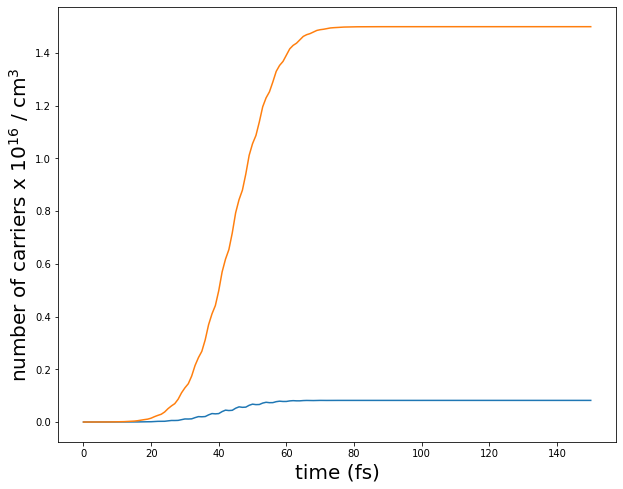

In [12]:
# bands 49-56
bohr_cm = U.Constants.Bohr_radius*1e2
vol_direct = results[0].dft.eval_lattice_volume()*bohr_cm**3

fig, ax = plt.subplots(figsize=(10, 8))

for r in results.values():
    data = r.data['carriers']
    t = data['time']
    dne = data['dne']
    ax.plot(t,dne/vol_direct/1e16)
ax.set_xlabel('time (fs)',size=20)
ax.set_ylabel('number of carriers x $10^{16}$ / cm$^3$',size=20)

Text(0, 0.5, 'number of carriers x $10^{16}$ / cm$^3$')

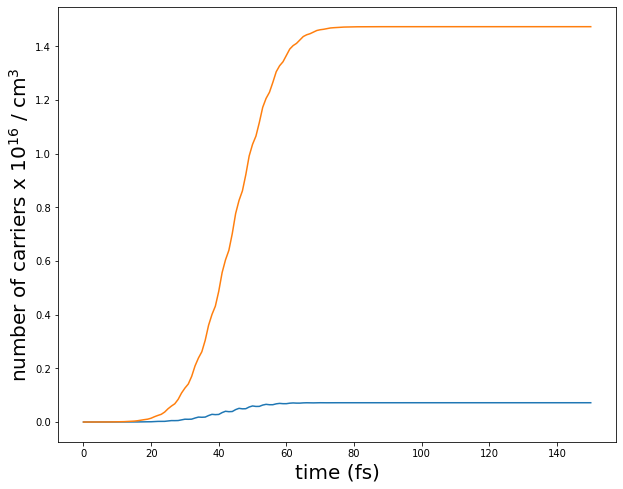

In [117]:
# bands 49-54
bohr_cm = U.Constants.Bohr_radius*1e2
vol_direct = results[0].dft.eval_lattice_volume()*bohr_cm**3

fig, ax = plt.subplots(figsize=(10, 8))

for r in results.values():
    data = r.data['carriers']
    t = data['time']
    dne = data['dne']
    ax.plot(t,dne/vol_direct/1e16)
ax.set_xlabel('time (fs)',size=20)
ax.set_ylabel('number of carriers x $10^{16}$ / cm$^3$',size=20)

Text(0, 0.5, 'number of carriers x $10^{16}$ / cm$^3$')

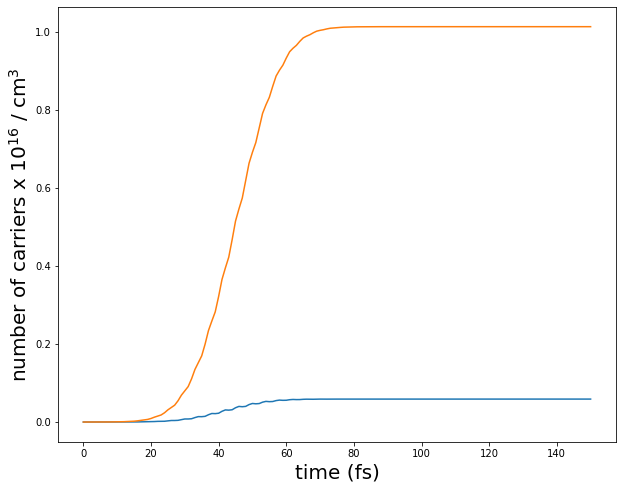

In [108]:
# bands 51-56
bohr_cm = U.Constants.Bohr_radius*1e2
vol_direct = results[0].dft.eval_lattice_volume()*bohr_cm**3

fig, ax = plt.subplots(figsize=(10, 8))

for r in results.values():
    data = r.data['carriers']
    t = data['time']
    dne = data['dne']
    ax.plot(t,dne/vol_direct/1e16)
ax.set_xlabel('time (fs)',size=20)
ax.set_ylabel('number of carriers x $10^{16}$ / cm$^3$',size=20)

Text(0, 0.5, 'number of carriers x $10^{16}$ / cm$^3$')

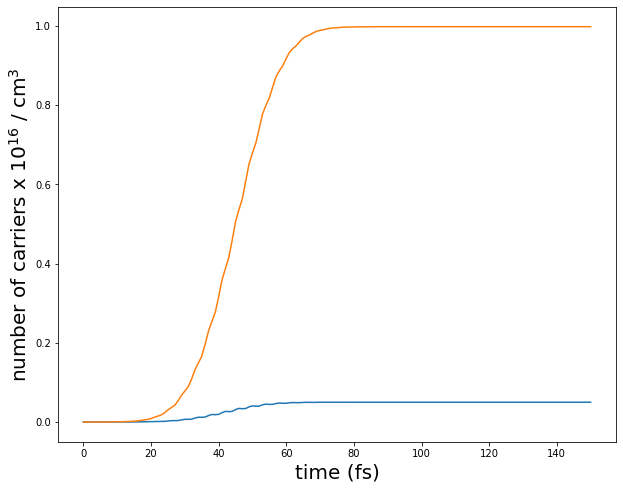

In [135]:
# bands 51-54
bohr_cm = U.Constants.Bohr_radius*1e2
vol_direct = results[0].dft.eval_lattice_volume()*bohr_cm**3

fig, ax = plt.subplots(figsize=(10, 8))

for r in results.values():
    data = r.data['carriers']
    t = data['time']
    dne = data['dne']
    ax.plot(t,dne/vol_direct/1e16)
ax.set_xlabel('time (fs)',size=20)
ax.set_ylabel('number of carriers x $10^{16}$ / cm$^3$',size=20)

On the basis of this analysis we observe that the bands from 49 to 54 are sufficient to describe
the absorption at 1.55 eV

Now we perform RT simulations in function of the field intensity to test the linear response range

In [15]:
n_tasks = ntasks_per_node*nodes

field_int = [1e7,2e7,5e7,1e8,5e8,1e9] # intensity of the pulses in kW/cm^2
fwhm = 35 # fs 
energy = 1.55 # eV
time_step = 10 # as
sim_time = 150 # fs
bands =  [49,54] #[49,56]  
scissor = 0.261
eta = 0.05 # eV
io_time = [10.0,10.0,1.]  # I/O (CARRIERs - GF - OUTPUT) in fs 
io_cache_time = [1.,10.] # Time between two consecutive (caching - I/O) of OBSERVABLES in fs

study = D.Dataset(run_dir=run_dir,num_tasks=1,verbose=True,skip=True)
study.set_postprocessing_function(PP.yambo_parse_data)

inp = I.YamboInput('yambo_rt -n p -v hsex -e -V rt',folder=run_dir)
inp.set_rt_bands(bands=bands,scissor=scissor,damping_valence=eta,damping_conduction=eta)
inp.set_rt_simulationTimes(sim_time=sim_time,io_time=io_time,io_cache_time=io_cache_time,time_step=time_step)
inp.set_rt_cpu(k=16,b=4) # 2 nodes - 64 mpi
#inp.set_rt_cpu(k=16,b=2) # 1 node - 32 mpi
inp.set_array_variables(COLLBands=bands)
inp.set_scalar_variables(HXC_Potential='SEX+HARTREE')
for f in field_int:
    inp.set_rt_field(int=f,fwhm=fwhm,polarization='linear',freq=energy)
    idd = 'sex_field-int_%s-energy_%s-bands_%s-%s'%(f,energy,bands[0],bands[1])
    #idd = 'test'
    study.append_run(id=idd,input=inp,runner=code,jobname=[idd,
        'em1s-ngsblkxs_200-bndsrnxs_100','ndb_dipoles-coll-bands_%s-%s'%(bands[0],bands[1])])

Initialize a Dataset with 1 parallel tasks


In [16]:
study.runs[0]

{'label': 'Dataset',
 'run_dir': 'NEQ_RT/12x12x3/FixSymm',
 'num_tasks': 1,
 'verbose': True,
 'skip': True,
 'input': {'args': 'yambo_rt -n p -v hsex -e -V rt',
  'folder': 'NEQ_RT/12x12x3/FixSymm',
  'filename': 'yambo.in',
  'arguments': ['life', 'collisions', 'negf'],
  'variables': {'RT_Threads': [0.0, ''],
   'HARRLvcs': [38691.0, 'RL'],
   'EXXRLvcs': [38691.0, 'RL'],
   'CORRLvcs': [38691.0, 'RL'],
   'GfnRT_N': [1.0, ''],
   'dTupdateTime': [0.0, 'fs'],
   'dTupdateTimeSet': [-0.024189, 'fs'],
   'dTupdateJump': [0.0, 'fs'],
   'dTupdateTresh': [0.1, ''],
   'dT_MAX': [-1.0, 'fs'],
   'dT_SET': [0.0, ''],
   'ScattTresh': [-1.0, 'eV'],
   'RADLifeTime': [0.0, 'fs'],
   'RADmagnific': [1.0, ''],
   'PhLifeTime': [0.0, 'fs'],
   'DephEThresh': [0.000272114, 'eV'],
   'RTstep': [10, 'as'],
   'NETime': [150, 'fs'],
   'Field1_NFreqs': [1.0, ''],
   'Field1_DFreq': [0.0, 'eV'],
   'Field1_Int': [10000000.0, 'kWLm2'],
   'Field1_Width': [0.0, 'fs'],
   'Field1_FWHM': [35, 'fs'],
  

In [17]:
results = study.run()

Run the selection [0] with the parallel task_groups [[0]] 

Run the task [0] 
run command: mpirun -np 32 yambo_rt -F test.in -J "test,em1s-ngsblkxs_200-bndsrnxs_100,ndb_dipoles-coll-bands_49-54" -C test
slurm submit:  cd NEQ_RT/12x12x3/FixSymm ; sbatch job_test.sh
computation test is running...
computation test ended

        There are no o-* files.
        Maybe you have performed a computation that does not create any output file or wait_end_run
        and/or the dry_run option are active.
        Otherwise a possible error has occured during the computation
        
game_over string not found in report. Check the computation!
Task [0] ended 
 


In [9]:
bohr_cm = U.Constants.Bohr_radius*1e2
vol_direct = results[0].dft.eval_lattice_volume()*bohr_cm**3

Text(0, 0.5, 'number of carriers x $10^{16}$ / cm$^3$')

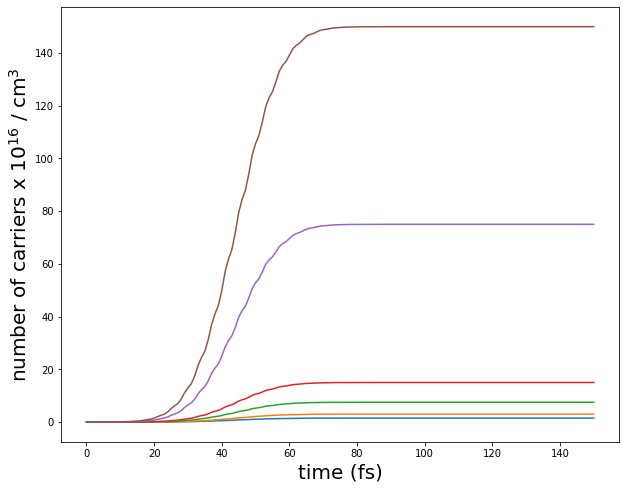

In [10]:
# bands 49-56
fig, ax = plt.subplots(figsize=(10, 8))

for r in results.values():
    data = r.data['carriers']
    t = data['time']
    dne = data['dne']
    ax.plot(t,dne/vol_direct/1e16)
ax.set_xlabel('time (fs)',size=20)
ax.set_ylabel('number of carriers x $10^{16}$ / cm$^3$',size=20)

Text(0, 0.5, 'number of carriers x $10^{16}$ / cm$^3$')

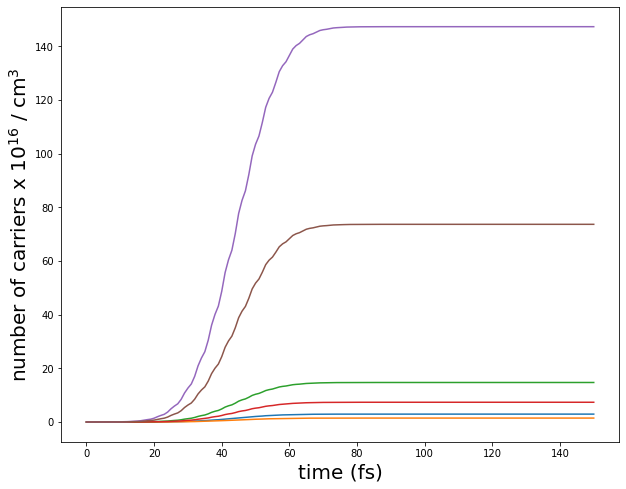

In [170]:
# bands 49-54
fig, ax = plt.subplots(figsize=(10, 8))

for r in results.values():
    data = r.data['carriers']
    t = data['time']
    dne = data['dne']
    ax.plot(t,dne/vol_direct/1e16)
ax.set_xlabel('time (fs)',size=20)
ax.set_ylabel('number of carriers x $10^{16}$ / cm$^3$',size=20)

Text(0, 0.5, 'number of carriers x $10^{16}$ / cm$^3$')

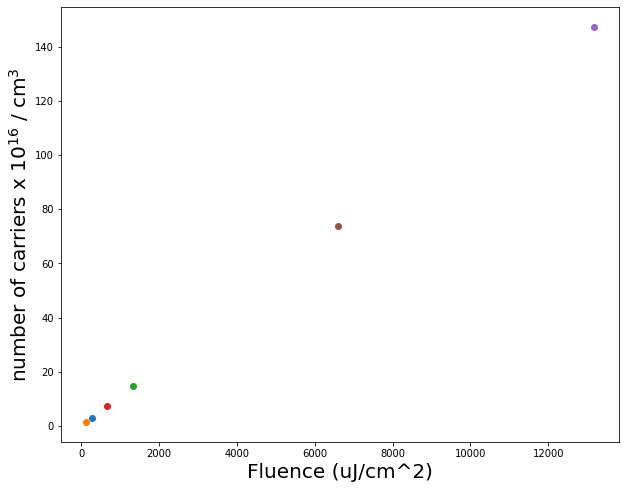

In [171]:
# bands 49-54
fluence,carriers = [],[]

for r in results.values():
    data = r.data['external_field']
    fluence.append(data['Fluence'][-1]/1e3)             
    data = r.data['carriers']
    carriers.append(data['dne'][-1]/vol_direct/1e16)

fig, ax = plt.subplots(figsize=(10, 8))

for f,c in zip(fluence,carriers):
    ax.scatter(f,c)
ax.set_xlabel('Fluence (uJ/cm^2)',size=20)
ax.set_ylabel('number of carriers x $10^{16}$ / cm$^3$',size=20)

### Analysis of the k and time resolved occupations

In [13]:
from mppi.Utilities.Utils import file_parser

In [14]:
# RunRules for ismhpc
# The product of ntasks_per_node*cpus_per_task is equal to 32. 
# Many mpi are needed for better performances
nodes = 1
ntasks_per_node = 32
cpus_per_task=1
omp_num_threads=1

ntasks = nodes*ntasks_per_node

rr = C.RunRules(scheduler='slurm',partition='all12h', #fastnodes
                memory='124000',
                nodes=nodes,ntasks_per_node=ntasks_per_node,
                cpus_per_task=cpus_per_task,
                omp_num_threads=omp_num_threads)
ypp_code = C.YamboCalculator(rr,executable='ypp_rt',activate_BeeOND=True) 
#ypp_code.global_options()

Initialize a Yambo calculator with scheduler slurm


In [15]:
run_path = 'NEQ_RT'
k = '12x12x3'
run_dir = os.path.join(run_path,k,'FixSymm')
scissor = 0.261

# The coordinates of the high sym points are provided in crystal coordinates
# to match the 'rlu' in the ypp inpuy
G = [0.,0.,0.]
K = [1./3.,1./3.,0.]
M = [0.5,0.,0.]
high_sym = {'G':G,'K':K,'M':M} # useful to label the high-sym point on the path

In [16]:
bands_step = 50
scissor = 0.261 # eV

inp = I.YamboInput('ypp_rt -rtplot o -rtmode b -V All',folder=run_dir,filename='ypp_rt.in')
inp['arguments'].append('IncludeEQocc')
inp.set_array_variables(units='fs',TimeStep=50)
inp.set_array_variables(BANDS_steps=bands_step,GfnQP_E=[scissor,1.,1.])
inp.set_scalar_variables(BANDS_path='G M K G',INTERP_mode='BOLTZ')
inp

{'args': 'ypp_rt -rtplot o -rtmode b -V All',
 'folder': 'NEQ_RT/12x12x3/FixSymm',
 'filename': 'ypp_rt.in',
 'arguments': ['RToccupations', 'RTfitbands', 'IncludeEQocc'],
 'variables': {'ElecTemp': [0.0, 'eV'],
  'BoseTemp': [-1.0, 'eV'],
  'StdoHash': [40.0, ''],
  'PROJECT_depth': [1.0, ''],
  'PROJECT_threshold': [5.0, ''],
  'INTERP_Shell_Fac': [20.0, ''],
  'INTERP_NofNN': [1.0, ''],
  'OutputAlat': [0.0, ''],
  'NelFac': [1.0, ''],
  'BANDS_steps': [50, ''],
  'TimeStep': [50, 'fs'],
  'PROJECT_mode': 'none',
  'INTERP_mode': 'BOLTZ',
  'cooIn': 'rlu',
  'cooOut': 'rlu',
  'CIRCUIT_E_DB_path': 'none',
  'TimeRange': [['-1.000000', '-1.000000'], 'fs'],
  'GfnQP_E': [[0.261, 1.0, 1.0], ''],
  'BANDS_path': 'G M K G'}}

In [17]:
study = D.Dataset(run_dir=run_dir,num_tasks=1,verbose=True,skip=False)
#study.set_postprocessing_function(PP.yambo_parse_data)

idd = 'ypp_rt-bands-ip'
study.append_run(id=idd,input=inp,runner=ypp_code,jobname=[idd,'ip_field-int_1e7-energy_1.55-bands_49-56'])
idd = 'ypp_rt-bands-sex'
study.append_run(id=idd,input=inp,runner=ypp_code,jobname=[idd,'sex_field-int_1e7-energy_1.55-bands_49-56'])


Initialize a Dataset with 1 parallel tasks


In [18]:
study.runs[0]

{'label': 'Dataset',
 'run_dir': 'NEQ_RT/12x12x3/FixSymm',
 'num_tasks': 1,
 'verbose': True,
 'skip': False,
 'input': {'args': 'ypp_rt -rtplot o -rtmode b -V All',
  'folder': 'NEQ_RT/12x12x3/FixSymm',
  'filename': 'ypp_rt.in',
  'arguments': ['RToccupations', 'RTfitbands', 'IncludeEQocc'],
  'variables': {'ElecTemp': [0.0, 'eV'],
   'BoseTemp': [-1.0, 'eV'],
   'StdoHash': [40.0, ''],
   'PROJECT_depth': [1.0, ''],
   'PROJECT_threshold': [5.0, ''],
   'INTERP_Shell_Fac': [20.0, ''],
   'INTERP_NofNN': [1.0, ''],
   'OutputAlat': [0.0, ''],
   'NelFac': [1.0, ''],
   'BANDS_steps': [50, ''],
   'TimeStep': [50, 'fs'],
   'PROJECT_mode': 'none',
   'INTERP_mode': 'BOLTZ',
   'cooIn': 'rlu',
   'cooOut': 'rlu',
   'CIRCUIT_E_DB_path': 'none',
   'TimeRange': [['-1.000000', '-1.000000'], 'fs'],
   'GfnQP_E': [[0.261, 1.0, 1.0], ''],
   'BANDS_path': 'G M K G'}},
 'jobname': ['ypp_rt-bands-ip', 'ip_field-int_1e7-energy_1.55-bands_49-56'],
 'name': 'ypp_rt-bands-ip'}

In [19]:
results = study.run()

Run the selection [0, 1] with the parallel task_groups [[0], [1]] 

Run the task [0] 
delete job_out script: NEQ_RT/12x12x3/FixSymm/job_ypp_rt-bands-ip.out
delete folder: NEQ_RT/12x12x3/FixSymm/ypp_rt-bands-ip
run command: mpirun -np 32 ypp_rt -F ypp_rt-bands-ip.in -J "ypp_rt-bands-ip,ip_field-int_1e7-energy_1.55-bands_49-56" -C ypp_rt-bands-ip
slurm submit:  cd NEQ_RT/12x12x3/FixSymm ; sbatch job_ypp_rt-bands-ip.sh
computation ypp_rt-bands-ip is running...
computation ypp_rt-bands-ip ended
Run performed in 03s
Task [0] ended 
 
Run the task [1] 
delete job_out script: NEQ_RT/12x12x3/FixSymm/job_ypp_rt-bands-sex.out
delete folder: NEQ_RT/12x12x3/FixSymm/ypp_rt-bands-sex
run command: mpirun -np 32 ypp_rt -F ypp_rt-bands-sex.in -J "ypp_rt-bands-sex,sex_field-int_1e7-energy_1.55-bands_49-56" -C ypp_rt-bands-sex
slurm submit:  cd NEQ_RT/12x12x3/FixSymm ; sbatch job_ypp_rt-bands-sex.sh
computation ypp_rt-bands-sex is running...
computation ypp_rt-bands-sex ended
Run performed in 03s
Task [1

We create a BandStructure object using a ypp computation with the same parameters of this one

In [23]:
ypp_data = 'BANDS/12x12x3/ypp_bands_dft_rt-parameters/o-ypp_bands_dft_rt-parameters.bands_interpolated'
ypp_bands = U.BandStructure.from_Ypp_file(ypp_data,high_sym)

We parse the ypp_rt results (for each time) and we plot the RT occupations over the EQ bands

#### IP level

In [36]:
ip_path = 'NEQ_RT/12x12x3/FixSymm/ypp_rt-bands-ip'
files = []
for file in os.listdir(ip_path):
        if 'o-' in file: files.append(file)
files

['o-ypp_rt-bands-ip.YPP-RT_occ_bands_T_0.000000',
 'o-ypp_rt-bands-ip.YPP-RT_occ_bands_T_50.00000',
 'o-ypp_rt-bands-ip.YPP-RT_occ_bands_T_100.0000',
 'o-ypp_rt-bands-ip.YPP-RT_occ_bands_T_150.0000']

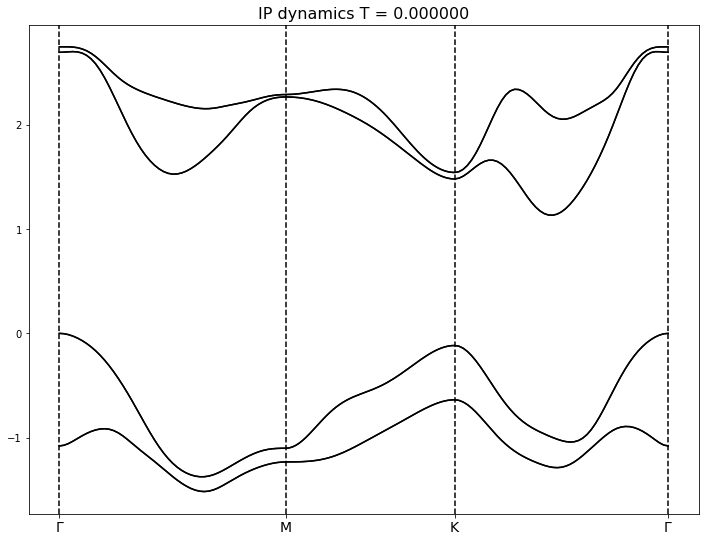

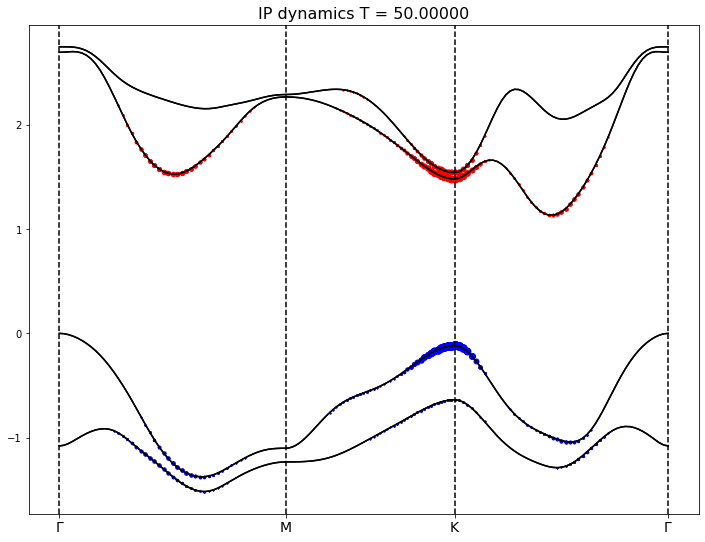

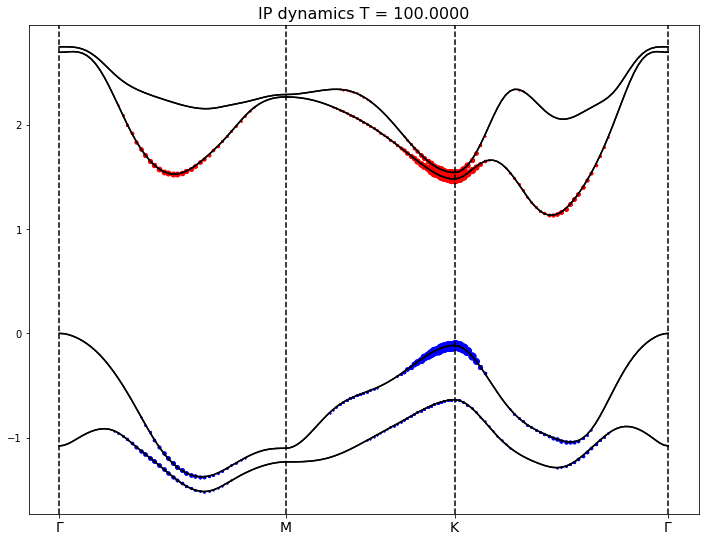

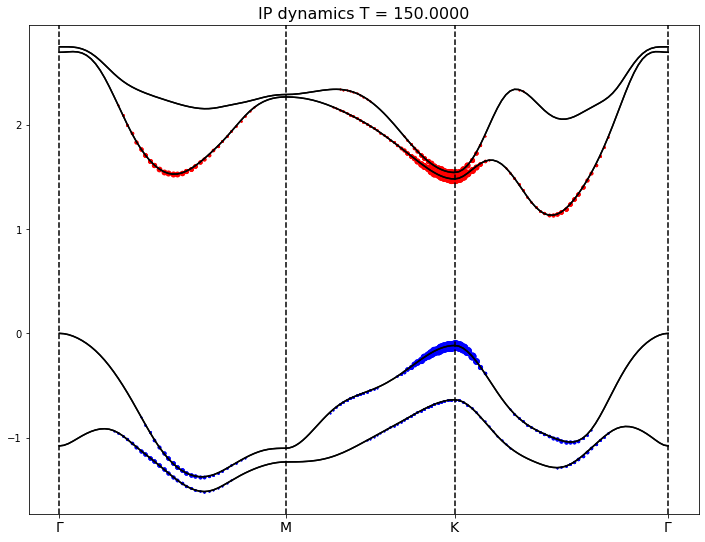

In [39]:
numBands = 8
shift = 0.

kpath = ypp_bands.get_kpath()
for f in files:
    data = file_parser(os.path.join(ip_path,f))
    energy = np.array_split(data[1],numBands)
    occ = np.array_split(data[2],numBands)
    fig, ax = plt.subplots(figsize=(12, 9))
    ypp_bands.plot(plt,linestyle='-',c='black')

    for ind_b in range(numBands):
        for ind in range(len(kpath)):
            x,y,o = kpath[ind],energy[ind_b][ind],occ[ind_b][ind]
            if o < 0 : color = 'blue'
            if o >= 0 : color = 'red'
            plt.scatter(x,shift+y,s=abs(int(1e8*o)),c=color)
    plt.title('IP dynamics T = %s'%f.split('_')[-1],size=16)
    plt.show()
    

#### SEX level

In [42]:
ip_path = 'NEQ_RT/12x12x3/FixSymm/ypp_rt-bands-sex'
files = []
for file in os.listdir(ip_path):
        if 'o-' in file: files.append(file)
files

['o-ypp_rt-bands-sex.YPP-RT_occ_bands_T_0.000000',
 'o-ypp_rt-bands-sex.YPP-RT_occ_bands_T_50.00000',
 'o-ypp_rt-bands-sex.YPP-RT_occ_bands_T_100.0000',
 'o-ypp_rt-bands-sex.YPP-RT_occ_bands_T_150.0000']

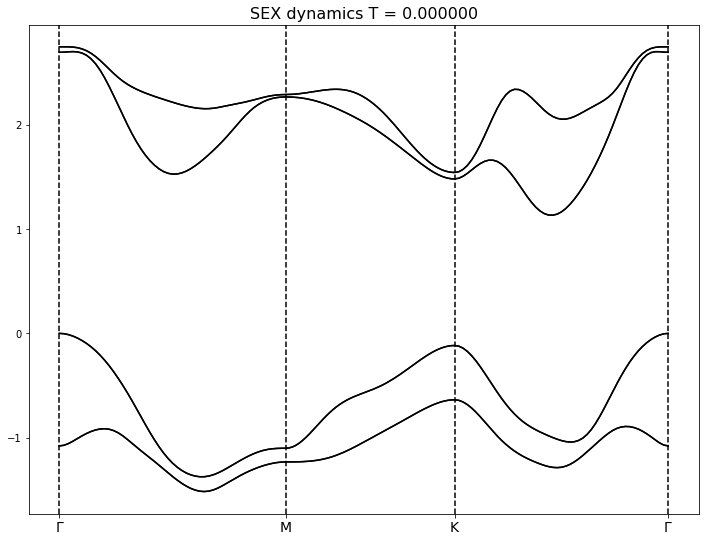

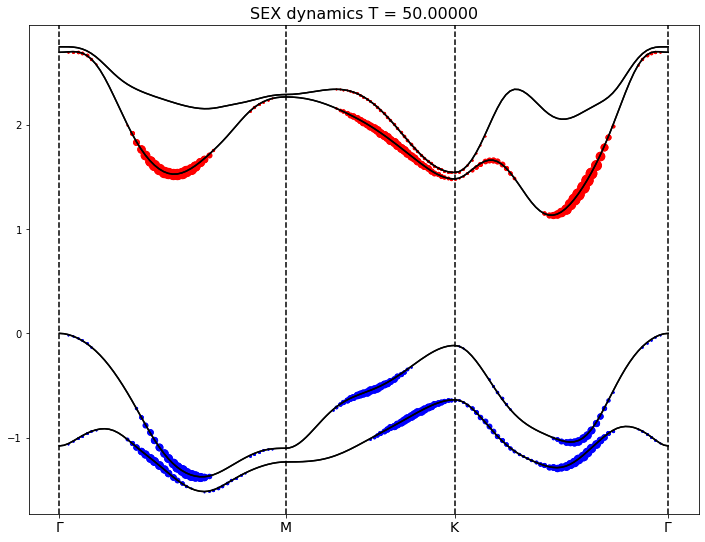

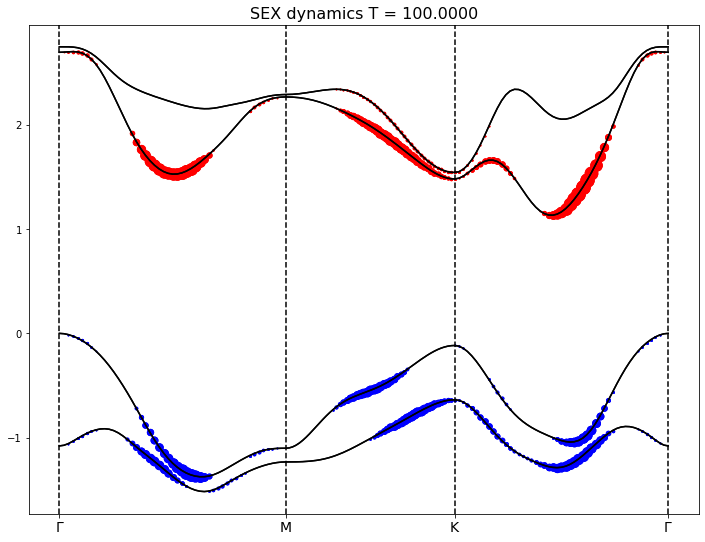

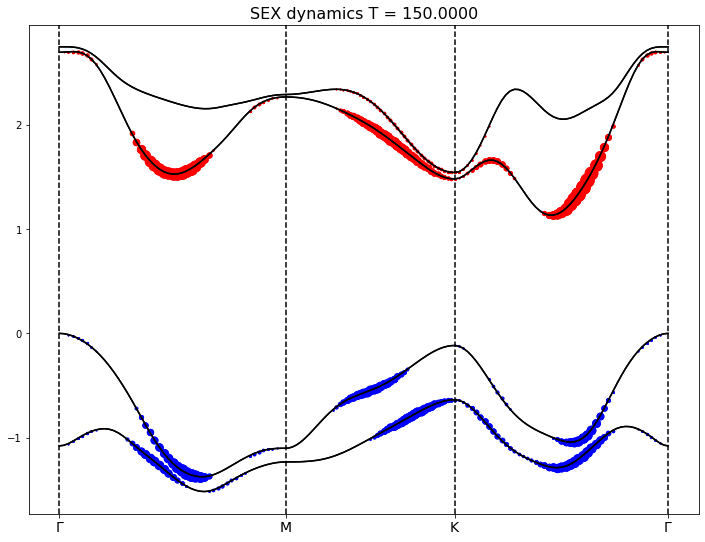

In [43]:
numBands = 8
shift = 0.

kpath = ypp_bands.get_kpath()
for f in files:
    data = file_parser(os.path.join(ip_path,f))
    energy = np.array_split(data[1],numBands)
    occ = np.array_split(data[2],numBands)
    fig, ax = plt.subplots(figsize=(12, 9))
    ypp_bands.plot(plt,linestyle='-',c='black')

    for ind_b in range(numBands):
        for ind in range(len(kpath)):
            x,y,o = kpath[ind],energy[ind_b][ind],occ[ind_b][ind]
            if o < 0 : color = 'blue'
            if o >= 0 : color = 'red'
            plt.scatter(x,shift+y,s=abs(int(5e7*o)),c=color)
    plt.title('SEX dynamics T = %s'%f.split('_')[-1],size=16)
    plt.show()
    

We study the projection option of this postprocessing

In [96]:
bands_step = 50
scissor = 0.261 # eV

inp = I.YamboInput('ypp_rt -rtplot o -rtmode b -V All',folder=run_dir,filename='ypp_rt.in')
inp['arguments'].append('IncludeEQocc')
inp.set_array_variables(units='fs',TimeStep=50)
inp.set_array_variables(BANDS_steps=bands_step,GfnQP_E=[scissor,1.,1.]) 
inp.set_scalar_variables(BANDS_path='G M K G',INTERP_mode='BOLTZ',PROJECT_mode='PLANE')
inp

{'args': 'ypp_rt -rtplot o -rtmode b -V All',
 'folder': 'NEQ_RT/12x12x3/FixSymm',
 'filename': 'ypp_rt.in',
 'arguments': ['RToccupations', 'RTfitbands', 'IncludeEQocc'],
 'variables': {'ElecTemp': [0.0, 'eV'],
  'BoseTemp': [-1.0, 'eV'],
  'StdoHash': [40.0, ''],
  'PROJECT_depth': [1.0, ''],
  'PROJECT_threshold': [5.0, ''],
  'INTERP_Shell_Fac': [20.0, ''],
  'INTERP_NofNN': [1.0, ''],
  'OutputAlat': [0.0, ''],
  'NelFac': [1.0, ''],
  'BANDS_steps': [50, ''],
  'TimeStep': [50, 'fs'],
  'PROJECT_mode': 'PLANE',
  'INTERP_mode': 'BOLTZ',
  'cooIn': 'rlu',
  'cooOut': 'rlu',
  'CIRCUIT_E_DB_path': 'none',
  'TimeRange': [['-1.000000', '-1.000000'], 'fs'],
  'GfnQP_E': [[0.261, 1.0, 1.0], ''],
  'BANDS_path': 'G M K G'}}

In [97]:
study = D.Dataset(run_dir=run_dir,num_tasks=1,verbose=True,skip=False)
#study.set_postprocessing_function(PP.yambo_parse_data)

idd = 'ypp_rt-test_bands-project_PLANE'
study.append_run(id=idd,input=inp,runner=ypp_code,jobname=[idd,'sex_field-int_20000000.0-energy_1.55-bands_49-56'])
#study.append_run(id=idd,input=inp,runner=ypp_code,jobname=[idd,'ip_field-int_20000000.0-energy_1.55-bands_49-56'])

Initialize a Dataset with 1 parallel tasks


In [98]:
#study.runs[0]

In [99]:
results = study.run()

Run the selection [0] with the parallel task_groups [[0]] 

Run the task [0] 
delete job_out script: NEQ_RT/12x12x3/FixSymm/job_ypp_rt-test_bands-project_PLANE.out
delete folder: NEQ_RT/12x12x3/FixSymm/ypp_rt-test_bands-project_PLANE
run command: mpirun -np 32 ypp_rt -F ypp_rt-test_bands-project_PLANE.in -J "ypp_rt-test_bands-project_PLANE,sex_field-int_20000000.0-energy_1.55-bands_49-56" -C ypp_rt-test_bands-project_PLANE
slurm submit:  cd NEQ_RT/12x12x3/FixSymm ; sbatch job_ypp_rt-test_bands-project_PLANE.sh
computation ypp_rt-test_bands-project_PLANE is running...
computation ypp_rt-test_bands-project_PLANE ended
Run performed in 04s
Task [0] ended 
 


We parse and analyze the o-files with the results

In [133]:
file = 'NEQ_RT/12x12x3/FixSymm/ypp_rt-test_bands-project_PLANE/o-ypp_rt-test_bands-project_PLANE.occupations_electrons_projected_PLANE_T_50.00000'
#file = 'NEQ_RT/12x12x3/FixSymm/ypp_rt-test_bands-project_PLANE/o-ypp_rt-test_bands-project_PLANE.occupations_holes_projected_PLANE_T_50.00000'
numk = bands_step+1
data = file_parser(file)
data.shape

(3, 2601)

In [134]:
Kx = np.array([data[0,numk*ind] for ind in range(numk)])
Ky = np.array([data[1,ind] for ind in range(numk)])
occ = np.reshape(data[2],(numk,numk))
#Kx,Ky

In [135]:
G_coord = np.array([0.,0.0])
M_coord = np.array([-0.34252563,0.])
K_coord = np.array([-0.342525661,0.114175245])

(-0.01, 0.12)

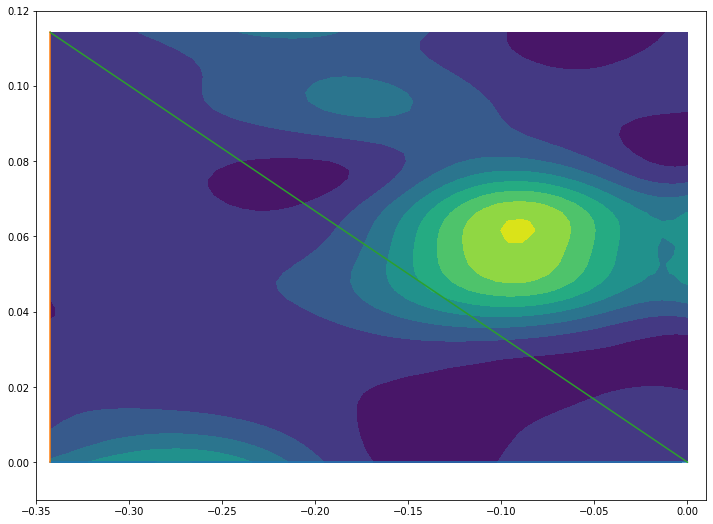

In [136]:
fig, ax = plt.subplots(figsize=(12, 9))
plt.plot([G_coord[0],M_coord[0]],[G_coord[1],M_coord[1]])
plt.plot([M_coord[0],K_coord[0]],[M_coord[1],K_coord[1]]) 
plt.plot([K_coord[0],G_coord[0]],[K_coord[1],G_coord[1]]) 
plt.contourf(Kx,Ky,occ)
plt.xlim(-0.35,0.01)
plt.ylim(-0.01,0.12)

We have to understand which is the meaning of the Kx and Ky coordinates. From the o- we know that

In [83]:
x_versor = np.array([-0.506847322,-0.292628467])
y_versor = np.array([-0.168949097,0.292628467])

In [85]:
Kx_cart = Kx*x_versor[0]+Ky*y_versor[0]
Ky_cart = Kx*x_versor[1]+Ky*y_versor[0]
Kx_cart,Ky_cart

(array([-0.        ,  0.00308637,  0.00617273,  0.00925909,  0.01234548,
         0.01543184,  0.01851821,  0.02160457,  0.02469094,  0.0277773 ,
         0.03086369,  0.03395005,  0.03703642,  0.04012278,  0.04320914,
         0.04629552,  0.04938187,  0.05246826,  0.05555463,  0.05864099,
         0.06172736,  0.06481372,  0.06790011,  0.07098646,  0.07407283,
         0.0771592 ,  0.08024556,  0.08333193,  0.08641828,  0.08950466,
         0.09259103,  0.09567741,  0.09876378,  0.10185014,  0.10493652,
         0.10802288,  0.11110925,  0.11419561,  0.11728198,  0.12036833,
         0.12345471,  0.12654109,  0.12962744,  0.13271381,  0.13580018,
         0.13888656,  0.14197293,  0.1450593 ,  0.14814565,  0.15123203,
         0.1543184 ]),
 array([-0.        ,  0.00161886,  0.00323771,  0.00485657,  0.00647544,
         0.0080943 ,  0.00971315,  0.01133201,  0.01295087,  0.01456973,
         0.01618859,  0.01780745,  0.01942631,  0.02104516,  0.02266402,
         0.02428288,  0.0259

In [126]:
Mx_cart = M_coord[0]*x_versor[0]+M_coord[1]*y_versor[0]
My_cart = M_coord[0]*x_versor[1]+M_coord[1]*y_versor[1]
Mx_cart,My_cart

(0.17360819828186289, 0.10023275001510921)

In [127]:
KKx_cart = K_coord[0]*x_versor[0]+K_coord[1]*y_versor[0]
KKy_cart = K_coord[0]*x_versor[1]+K_coord[1]*y_versor[1]
KKx_cart,KKy_cart

(0.1543184094516261, 0.13364368600029108)

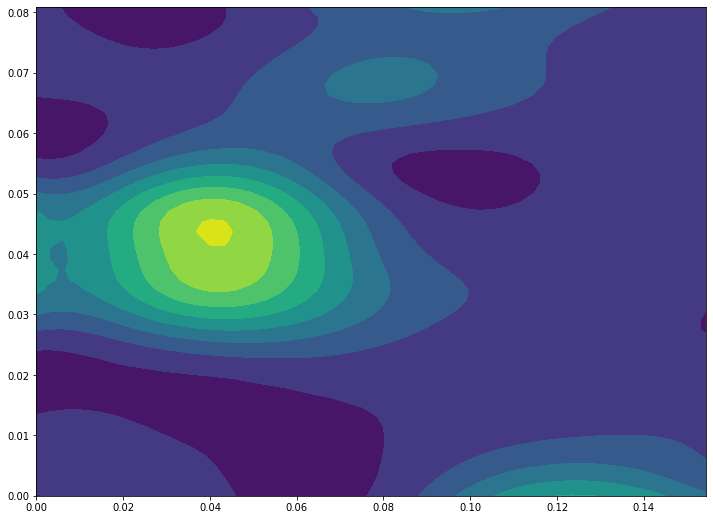

In [128]:
fig, ax = plt.subplots(figsize=(12, 9))

plt.contourf(Kx_cart,Ky_cart,occ)

At this level it remains to understand the precise meaning of the componenet of the k-points
in the basis used by the ypp_rt postprocessing.

It may be useful to perform a ypp computation with the option projection : plane, in this way
we can visualized the bands projected on the plane and we can recognize if the position 
of the high sym points indicated by ypp_rt are correct.

## Analysis of the NEQ dynamics with electron-phonon coupling

We study the non-equilibrium dynamics of the system with the electron-phonon coupling.

### Removal of the symmetries and computation of the screening function

We perform the FixSymm procedure and remove the symmetries broken by the field with linear polarization.

We work with 9x9x1 k-sampling in which we have performed the phonon analysis. Also we restrict the analysis
to 70 bands

In [4]:
run_path = 'NEQ_RT'
kpoints = ['9x9x1']

In [6]:
for k in kpoints: 
    input_dir = 'PHONON/nscf/WSe2.save'
    run_dir = os.path.join(run_path,k)
    rt_run_dir = os.path.join(run_dir,'FixSymm')

    Tools.init_yambo_dir(yambo_dir=run_dir,input_dir=input_dir)
    if not os.path.isdir(rt_run_dir):    
        fixSymm_inp = Tools.build_FixSymm_input(run_dir,polarization='linear')
        ypp_code = C.YamboCalculator(C.RunRules(),executable='ypp')
        ypp_code.run(input=fixSymm_inp,name='FixSymm',run_dir=run_dir)
        Tools.build_r_setup(yambo_dir=rt_run_dir)

SAVE folder NEQ_RT/9x9x1/SAVE already present. No operations performed.


In [5]:
elph_dir = 'PHONON/yambo/GKKP_expanded'
if not os.path.isdir('NEQ_RT/9x9x1/FixSymm/ndb_gkkp'):
    src = os.path.abspath(elph_dir)
    dest = os.path.abspath('NEQ_RT/9x9x1/FixSymm/ndb_gkkp')
    os.symlink(src,dest,target_is_directory=True)

The ems1s database has to be computed ex novo due to the FixSymm procedure.

In [10]:
k = kpoints[0]
run_dir = os.path.join(run_path,k,'FixSymm')

ntasks_c = 16
ntasks_v = int(ntasks/ntasks_c)
print(ntasks_c,ntasks_v)

NGsBlkXs = 200 # (RL) G size of the response function
NGsBlkXs_units = 'RL'
BndsRnXs = [1,70] # Polarization function bands
elec_field = [1.,0.,0.]

study = D.Dataset(num_tasks=1,verbose=True)
study.set_postprocessing_function(PP.yambo_parse_data)

inp = I.YamboInput('yambo -X s',folder=run_dir)
inp.set_array_variables(units=NGsBlkXs_units,NGsBlkXs=NGsBlkXs)
inp.set_array_variables(BndsRnXs=BndsRnXs,LongDrXs=elec_field)
inp.set_scalar_variables(SE_ROLEs='q.qp.b',SE_CPU='1.1.32') # for 1 nodes on ismhpc (with 32 mpi and 1 omp per node)
inp.set_scalar_variables(X_and_IO_ROLEs='q.g.k.c.v',X_and_IO_CPU='1.1.1.%s.%s'%(ntasks_c,ntasks_v))
idd = 'em1s-ngsblkxs_%s-bndsrnxs_%s'%(NGsBlkXs,BndsRnXs[1])
study.append_run(id=idd,input=inp,runner=code,run_dir=run_dir)

16 2
Initialize a Dataset with 1 parallel tasks


In [11]:
study.runs[0]

{'label': 'Dataset',
 'run_dir': 'NEQ_RT/9x9x1/FixSymm',
 'num_tasks': 1,
 'verbose': True,
 'input': {'args': 'yambo -X s',
  'folder': 'NEQ_RT/9x9x1/FixSymm',
  'filename': 'yambo.in',
  'arguments': ['em1s'],
  'variables': {'DIP_Threads': [0.0, ''],
   'X_Threads': [0.0, ''],
   'NGsBlkXs': [200, 'RL'],
   'Chimod': 'HARTREE',
   'XTermKind': 'none',
   'BndsRnXs': [[1, 70], ''],
   'LongDrXs': [[1.0, 0.0, 0.0], ''],
   'SE_ROLEs': 'q.qp.b',
   'SE_CPU': '1.1.32',
   'X_and_IO_ROLEs': 'q.g.k.c.v',
   'X_and_IO_CPU': '1.1.1.16.2'}},
 'name': 'em1s-ngsblkxs_200-bndsrnxs_70'}

In [28]:
results = study.run()

Run the selection [0] with the parallel task_groups [[0]] 

Run the task [0] 
run command: mpirun -np 32 yambo_rt -F em1s-ngsblkxs_200-bndsrnxs_70.in -J em1s-ngsblkxs_200-bndsrnxs_70 -C em1s-ngsblkxs_200-bndsrnxs_70
slurm submit:  cd NEQ_RT/9x9x1/FixSymm ; sbatch job_em1s-ngsblkxs_200-bndsrnxs_70.sh
computation em1s-ngsblkxs_200-bndsrnxs_70 is running...
computation em1s-ngsblkxs_200-bndsrnxs_70 ended

        There are no o-* files.
        Maybe you have performed a computation that does not create any output file or wait_end_run
        and/or the dry_run option are active.
        Otherwise a possible error has occured during the computation
        
Run performed in 33s
Task [0] ended 
 


### RT analysis

Now we peform a RT simulation

In [44]:
run_path = 'NEQ_RT'
k = '9x9x1'

In [45]:
run_dir = os.path.join(run_path,k,'FixSymm')
run_dir

'NEQ_RT/9x9x1/FixSymm'

In [46]:
n_tasks = ntasks_per_node*nodes

field_int = 1e7 # intensity of the pulses in kW/cm^2
field_int_str = '1e7'
Temp = 300 # K
fwhm = 35 # fs 
energy = 1.55 # eV
time_step = 10 # as
sim_time = 150 # fs
bands = [49,54]  
scissor = 0.261
eta = 0.05 # eV
io_time = [10.0,10.0,1.]  # I/O (CARRIERs - GF - OUTPUT) in fs 
io_cache_time = [1.,10.] # Time between two consecutive (caching - I/O) of OBSERVABLES in fs

study = D.Dataset(run_dir=run_dir,num_tasks=2,verbose=True,skip=True)
study.set_postprocessing_function(PP.yambo_parse_data)

inp = I.YamboInput('yambo_rt -n p -v ip -s ep -V all -J ndb_gkkp',folder=run_dir)
inp.set_rt_bands(bands=bands,scissor=scissor,damping_valence=eta,damping_conduction=eta)
inp.set_rt_simulationTimes(sim_time=sim_time,io_time=io_time,io_cache_time=io_cache_time,time_step=time_step)
inp.set_rt_cpu(ntasks)
inp.set_array_variables(units='K',ElecTemp=Temp)
#inp.set_scalar_variables(DBsIOoff='obs GF CARRIERs') # do not write these ndbs on disk
inp.set_rt_field(int=field_int,fwhm=fwhm,polarization='linear',freq=energy)
idd = 'ip_field-int_%s-energy_%s-Temp_%s-bands_%s-%s'%(field_int_str,energy,Temp,bands[0],bands[1])
study.append_run(id=idd,input=inp,runner=code,jobname=[idd,'ndb_gkkp','dipoles'])

inp = I.YamboInput('yambo_rt -n p -v hsex -s ep -e -V all -J ndb_gkkp',folder=run_dir)
inp.set_rt_bands(bands=bands,scissor=scissor,damping_valence=eta,damping_conduction=eta)
inp.set_rt_simulationTimes(sim_time=sim_time,io_time=io_time,io_cache_time=io_cache_time,time_step=time_step)
#inp.set_rt_cpu(k=16,b=4) # 2 nodes - 64 mpi
inp.set_rt_cpu(ntasks)
inp.set_array_variables(COLLBands=bands)
inp.set_scalar_variables(HXC_Potential='SEX+HARTREE')
inp.set_array_variables(units='K',ElecTemp=Temp)
inp.set_rt_field(int=field_int,fwhm=fwhm,polarization='linear',freq=energy)
idd = 'sex_field-int_%s-energy_%s-Temp_%s-bands_%s-%s'%(field_int_str,energy,Temp,bands[0],bands[1])
study.append_run(id=idd,input=inp,runner=code,jobname=[idd,'em1s-ngsblkxs_200-bndsrnxs_70','ndb_gkkp','dipoles'])
#inp

Initialize a Dataset with 2 parallel tasks


In [47]:
study.ids

['ip_field-int_1e7-energy_1.55-Temp_300-bands_49-54',
 'sex_field-int_1e7-energy_1.55-Temp_300-bands_49-54']

In [48]:
#study.runs[0]

In [49]:
results = study.run()

Run the selection [0, 1] with the parallel task_groups [[0, 1]] 

Run the task [0, 1] 
Skip the run of sex_field-int_1e7-energy_1.55-Temp_300-bands_49-54
Skip the run of ip_field-int_1e7-energy_1.55-Temp_300-bands_49-54
Task [0, 1] ended 
 


Text(0, 0.5, 'number of carriers x $10^{16}$ / cm$^3$')

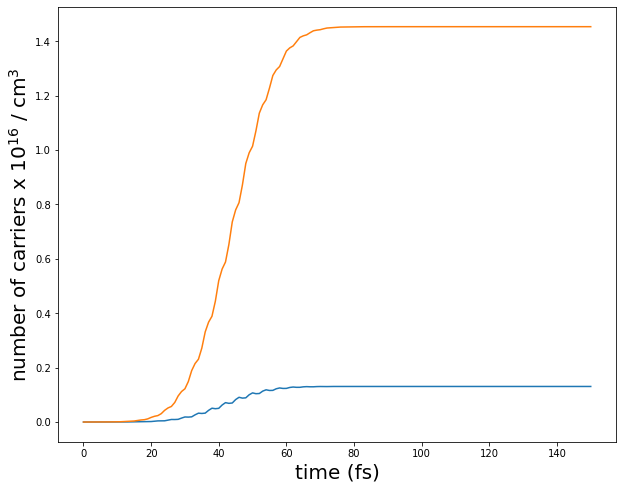

In [50]:
bohr_cm = U.Constants.Bohr_radius*1e2
vol_direct = results[1].dft.eval_lattice_volume()*bohr_cm**3
fig, ax = plt.subplots(figsize=(10, 8))

for r in results.values():
    data = r.data['carriers']
    t = data['col1']
    dne = data['col4']
    ax.plot(t,dne/vol_direct/1e16)
ax.set_xlabel('time (fs)',size=20)
ax.set_ylabel('number of carriers x $10^{16}$ / cm$^3$',size=20)

### Analysis of the k and time resolved occupations

In [51]:
from mppi.Utilities.Utils import file_parser

In [52]:
# RunRules for ismhpc
# The product of ntasks_per_node*cpus_per_task is equal to 32. 
# Many mpi are needed for better performances
nodes = 1
ntasks_per_node = 32
cpus_per_task=1
omp_num_threads=1

ntasks = nodes*ntasks_per_node

rr = C.RunRules(scheduler='slurm',partition='all12h', #fastnodes
                memory='124000',
                nodes=nodes,ntasks_per_node=ntasks_per_node,
                cpus_per_task=cpus_per_task,
                omp_num_threads=omp_num_threads)
ypp_code = C.YamboCalculator(rr,executable='ypp_rt',activate_BeeOND=True) 
#ypp_code.global_options()

Initialize a Yambo calculator with scheduler slurm


In [53]:
run_path = 'NEQ_RT'
k = '9x9x1'
run_dir = os.path.join(run_path,k,'FixSymm')
scissor = 0.261

# The coordinates of the high sym points are provided in crystal coordinates
# to match the 'rlu' in the ypp inpuy
G = [0.,0.,0.]
K = [1./3.,1./3.,0.]
M = [0.5,0.,0.]
high_sym = {'G':G,'K':K,'M':M} # useful to label the high-sym point on the path

In [54]:
bands_step = 50

inp = I.YamboInput('ypp_rt -rtplot o -rtmode b -V All',folder=run_dir,filename='ypp_rt.in')
inp['arguments'].append('IncludeEQocc')
inp.set_array_variables(units='fs',TimeStep=10)
inp.set_array_variables(BANDS_steps=bands_step,GfnQP_E=[scissor,1.,1.])
inp.set_scalar_variables(BANDS_path='G M K G',INTERP_mode='BOLTZ')
inp

{'args': 'ypp_rt -rtplot o -rtmode b -V All',
 'folder': 'NEQ_RT/9x9x1/FixSymm',
 'filename': 'ypp_rt.in',
 'arguments': ['RToccupations', 'RTfitbands', 'IncludeEQocc'],
 'variables': {'ElecTemp': [0.0, 'eV'],
  'BoseTemp': [-1.0, 'eV'],
  'StdoHash': [40.0, ''],
  'PROJECT_depth': [1.0, ''],
  'PROJECT_threshold': [5.0, ''],
  'INTERP_Shell_Fac': [20.0, ''],
  'INTERP_NofNN': [1.0, ''],
  'OutputAlat': [0.0, ''],
  'NelFac': [1.0, ''],
  'BANDS_steps': [50, ''],
  'TimeStep': [10, 'fs'],
  'PROJECT_mode': 'none',
  'INTERP_mode': 'BOLTZ',
  'cooIn': 'rlu',
  'cooOut': 'rlu',
  'CIRCUIT_E_DB_path': 'none',
  'TimeRange': [['-1.000000', '-1.000000'], 'fs'],
  'GfnQP_E': [[0.261, 1.0, 1.0], ''],
  'BANDS_path': 'G M K G'}}

In [55]:
study = D.Dataset(run_dir=run_dir,num_tasks=1,verbose=True,skip=True)
#study.set_postprocessing_function(PP.yambo_parse_data)

idd = 'ypp_rt-bands-ip'
study.append_run(id=idd,input=inp,runner=ypp_code,jobname=[idd,'ip_field-int_1e7-energy_1.55-Temp_300-bands_49-54'])
idd = 'ypp_rt-bands-sex'
study.append_run(id=idd,input=inp,runner=ypp_code,jobname=[idd,'sex_field-int_1e7-energy_1.55-Temp_300-bands_49-54'])

Initialize a Dataset with 1 parallel tasks


In [56]:
#study.runs[1]

In [57]:
results = study.run()

Run the selection [0, 1] with the parallel task_groups [[0], [1]] 

Run the task [0] 
Skip the run of ypp_rt-bands-ip
Task [0] ended 
 
Run the task [1] 
Skip the run of ypp_rt-bands-sex
Task [1] ended 
 


We create a BandStructure object using a ypp computation with the same parameters of this one

In [58]:
ypp_data = 'BANDS/9x9x1/ypp_bands_dft_rt-parameters/o-ypp_bands_dft_rt-parameters.bands_interpolated'
ypp_bands = U.BandStructure.from_Ypp_file(ypp_data,high_sym)

We parse the ypp_rt results (for each time) and we plot the RT occupations over the EQ bands

#### IP level

In [59]:
ip_path = 'NEQ_RT/9x9x1/FixSymm/ypp_rt-bands-ip'
files = []
for file in os.listdir(ip_path):
        if 'o-' in file: files.append(file)
files

['o-ypp_rt-bands-ip.YPP-RT_occ_bands_T_0.000000',
 'o-ypp_rt-bands-ip.YPP-RT_occ_bands_T_10.00000',
 'o-ypp_rt-bands-ip.YPP-RT_occ_bands_T_20.00000',
 'o-ypp_rt-bands-ip.YPP-RT_occ_bands_T_30.00000',
 'o-ypp_rt-bands-ip.YPP-RT_occ_bands_T_40.00000',
 'o-ypp_rt-bands-ip.YPP-RT_occ_bands_T_50.00000',
 'o-ypp_rt-bands-ip.YPP-RT_occ_bands_T_60.00000',
 'o-ypp_rt-bands-ip.YPP-RT_occ_bands_T_70.00000',
 'o-ypp_rt-bands-ip.YPP-RT_occ_bands_T_80.00000',
 'o-ypp_rt-bands-ip.YPP-RT_occ_bands_T_90.00001',
 'o-ypp_rt-bands-ip.YPP-RT_occ_bands_T_100.0000',
 'o-ypp_rt-bands-ip.YPP-RT_occ_bands_T_110.0000',
 'o-ypp_rt-bands-ip.YPP-RT_occ_bands_T_120.0000',
 'o-ypp_rt-bands-ip.YPP-RT_occ_bands_T_130.0000',
 'o-ypp_rt-bands-ip.YPP-RT_occ_bands_T_140.0000',
 'o-ypp_rt-bands-ip.YPP-RT_occ_bands_T_150.0000']

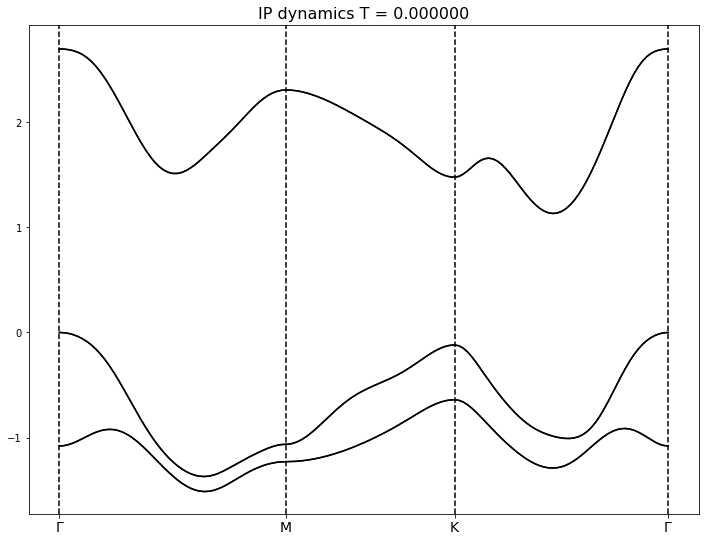

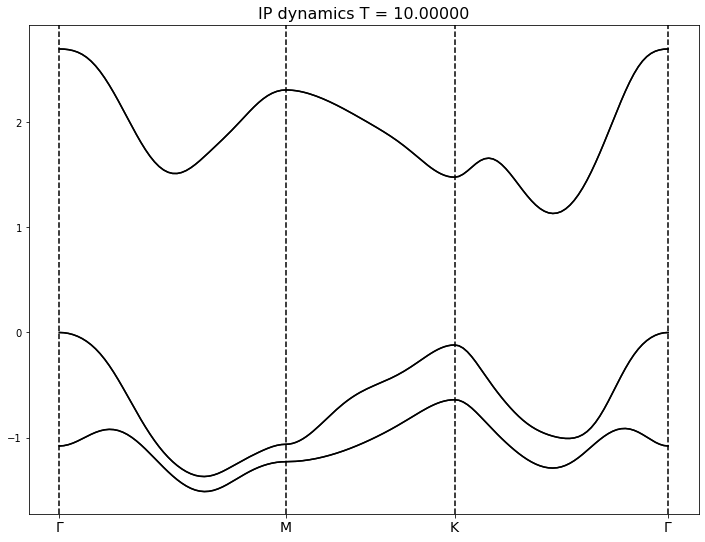

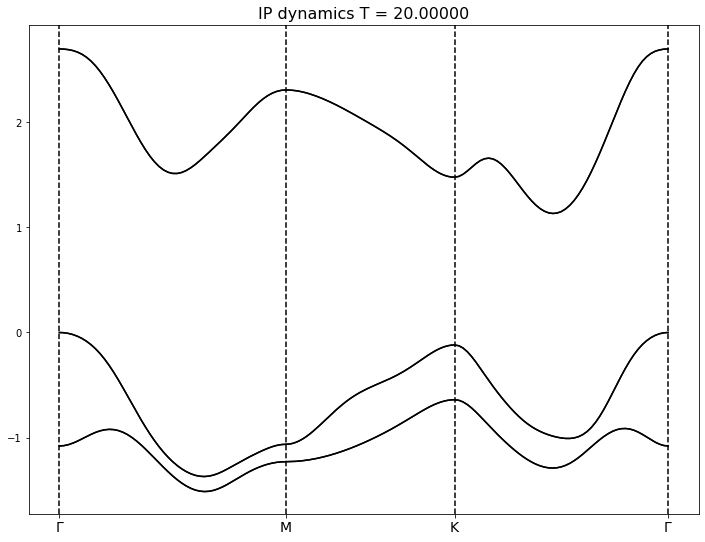

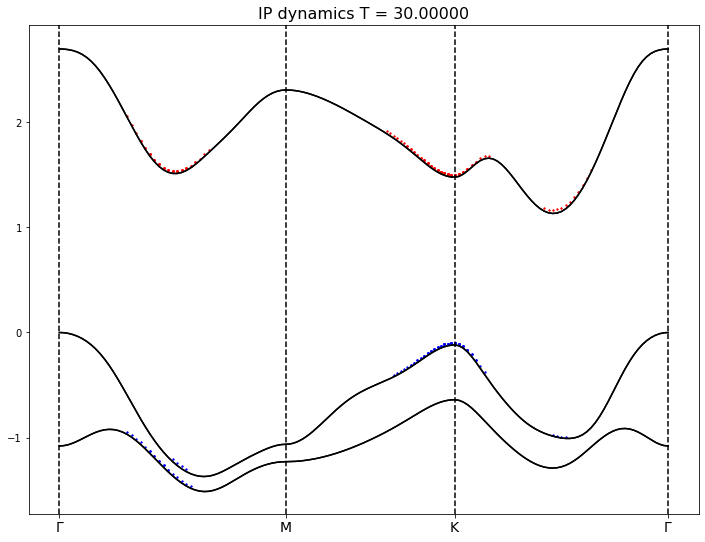

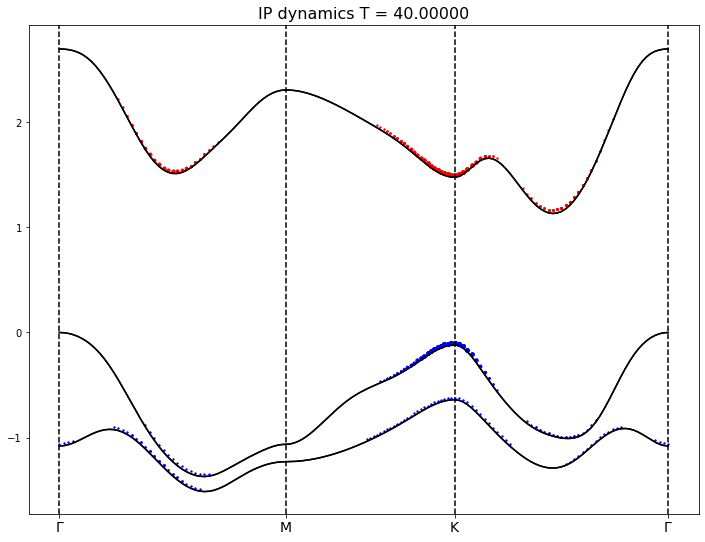

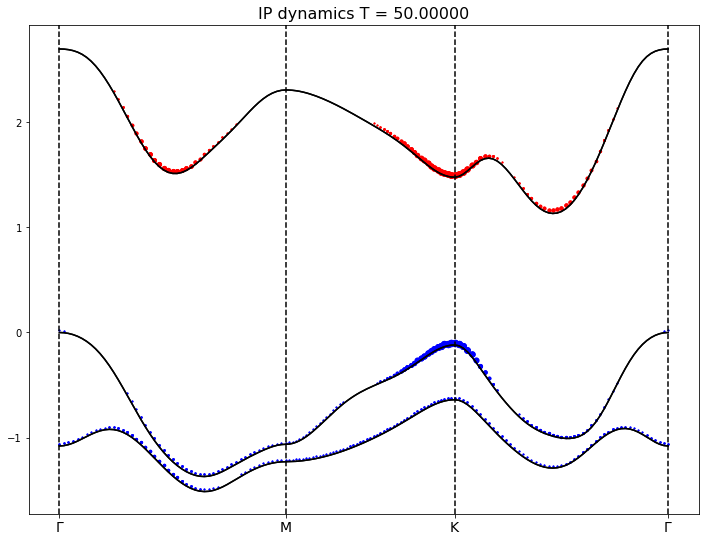

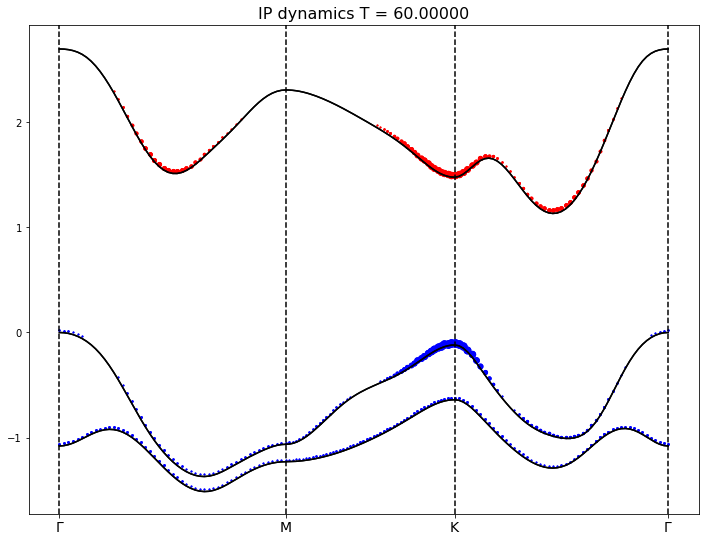

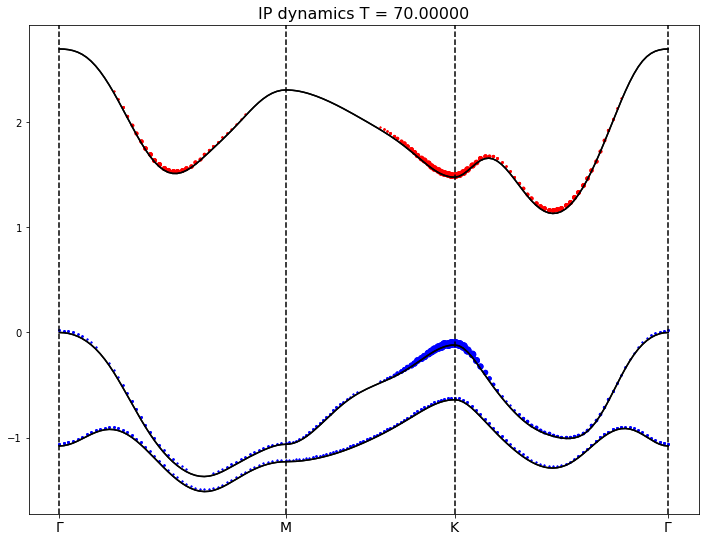

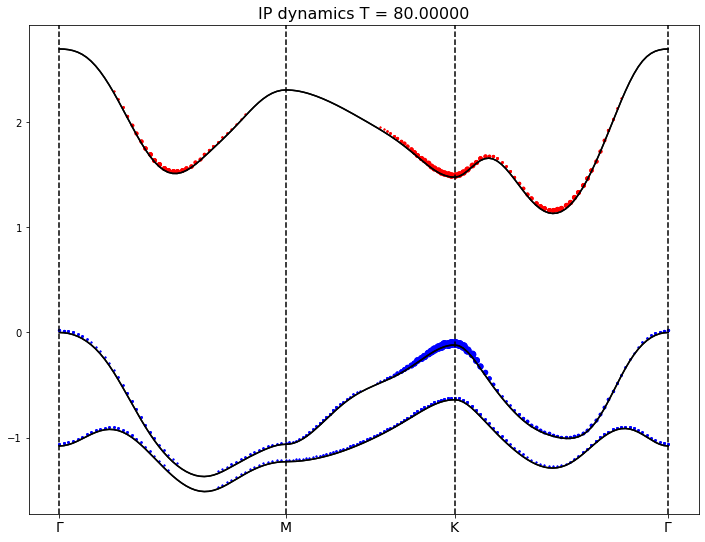

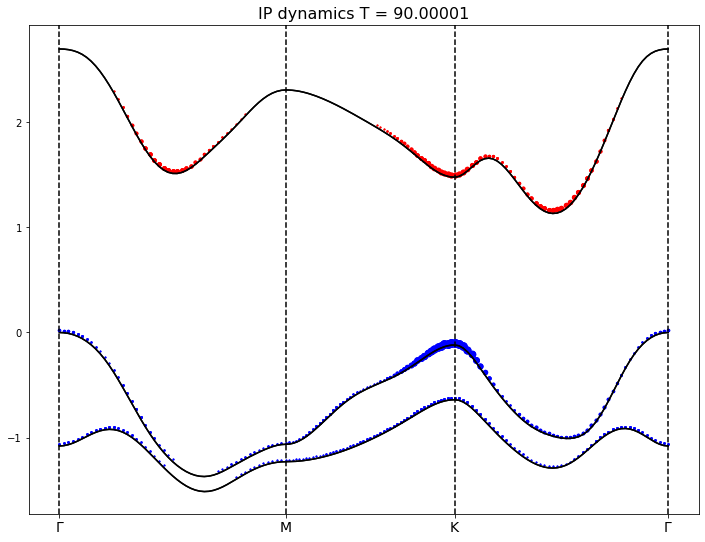

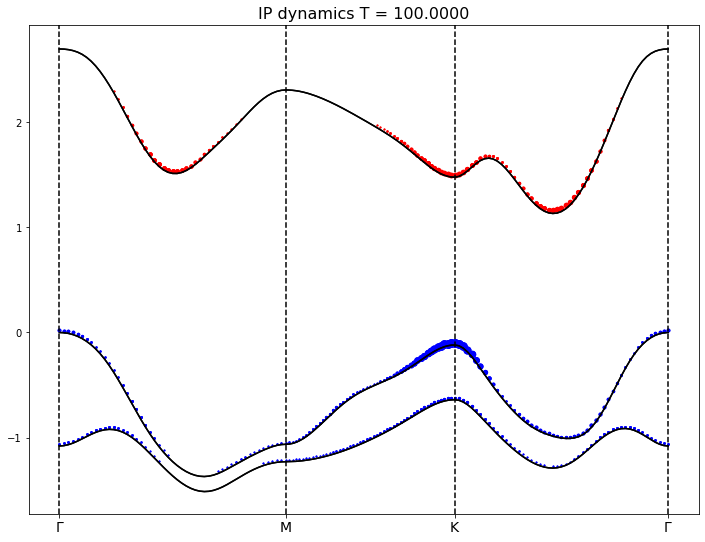

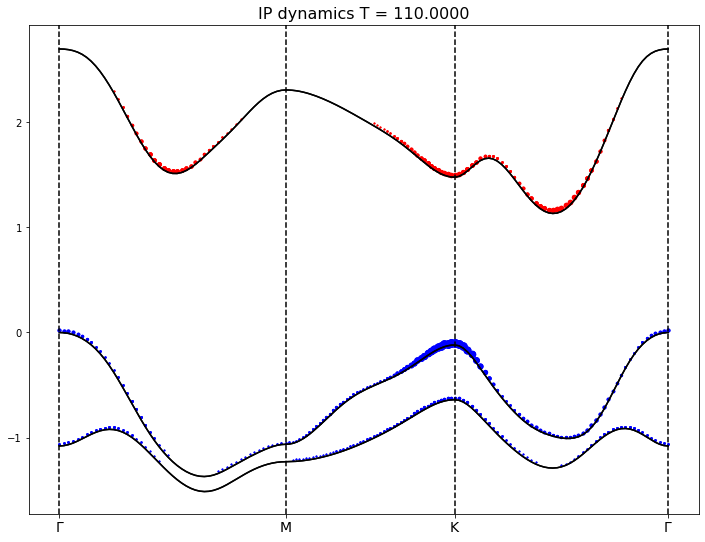

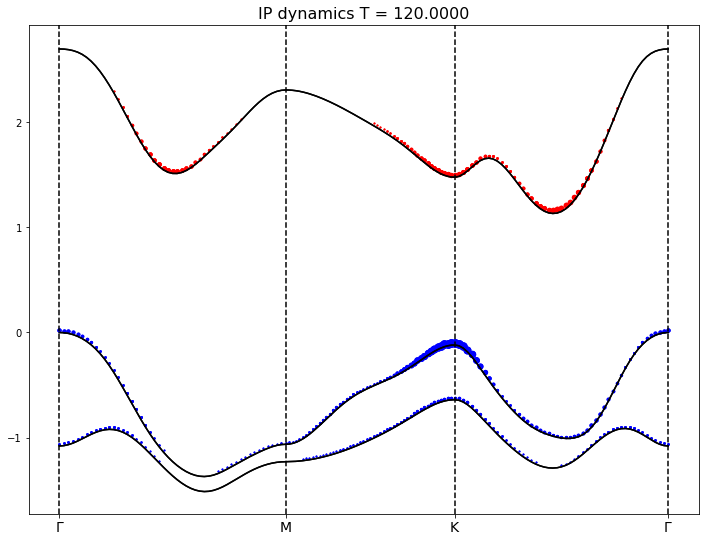

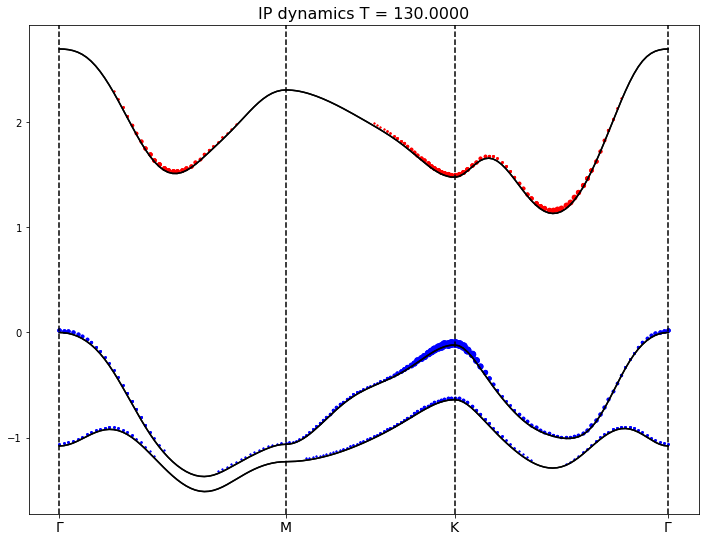

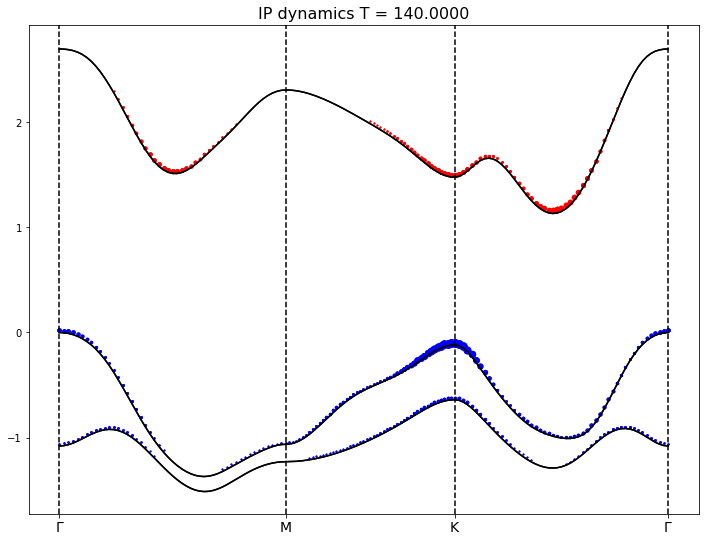

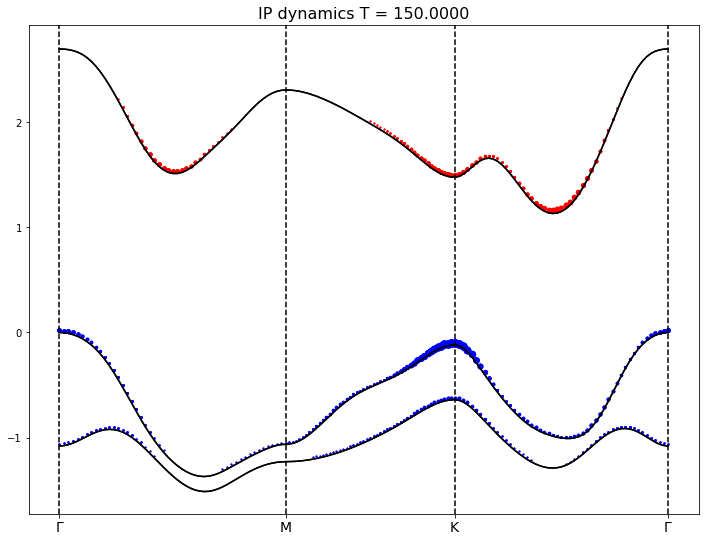

In [60]:
numBands = 6
shift = 0.6

kpath = ypp_bands.get_kpath()
for f in files:
    data = file_parser(os.path.join(ip_path,f))
    energy = np.array_split(data[1],numBands)
    occ = np.array_split(data[2],numBands)
    fig, ax = plt.subplots(figsize=(12, 9))
    ypp_bands.plot(plt,linestyle='-',c='black')

    for ind_b in range(numBands):
        for ind in range(len(kpath)):
            x,y,o = kpath[ind],energy[ind_b][ind],occ[ind_b][ind]
            if o < 0 : color = 'blue'
            if o >= 0 : color = 'red'
            plt.scatter(x,shift+y,s=abs(int(1e8*o)),c=color)
    plt.title('IP dynamics T = %s'%f.split('_')[-1],size=16)
    plt.show()
    

#### SEX level

In [61]:
sex_path = 'NEQ_RT/9x9x1/FixSymm/ypp_rt-bands-sex'
files = []
for file in os.listdir(sex_path):
        if 'o-' in file: files.append(file)
files

['o-ypp_rt-bands-sex.YPP-RT_occ_bands_T_0.000000',
 'o-ypp_rt-bands-sex.YPP-RT_occ_bands_T_10.00000',
 'o-ypp_rt-bands-sex.YPP-RT_occ_bands_T_20.00000',
 'o-ypp_rt-bands-sex.YPP-RT_occ_bands_T_30.00000',
 'o-ypp_rt-bands-sex.YPP-RT_occ_bands_T_40.00000',
 'o-ypp_rt-bands-sex.YPP-RT_occ_bands_T_50.00000',
 'o-ypp_rt-bands-sex.YPP-RT_occ_bands_T_60.00000',
 'o-ypp_rt-bands-sex.YPP-RT_occ_bands_T_70.00000',
 'o-ypp_rt-bands-sex.YPP-RT_occ_bands_T_80.00000',
 'o-ypp_rt-bands-sex.YPP-RT_occ_bands_T_90.00001',
 'o-ypp_rt-bands-sex.YPP-RT_occ_bands_T_100.0000',
 'o-ypp_rt-bands-sex.YPP-RT_occ_bands_T_110.0000',
 'o-ypp_rt-bands-sex.YPP-RT_occ_bands_T_120.0000',
 'o-ypp_rt-bands-sex.YPP-RT_occ_bands_T_130.0000',
 'o-ypp_rt-bands-sex.YPP-RT_occ_bands_T_140.0000',
 'o-ypp_rt-bands-sex.YPP-RT_occ_bands_T_150.0000']

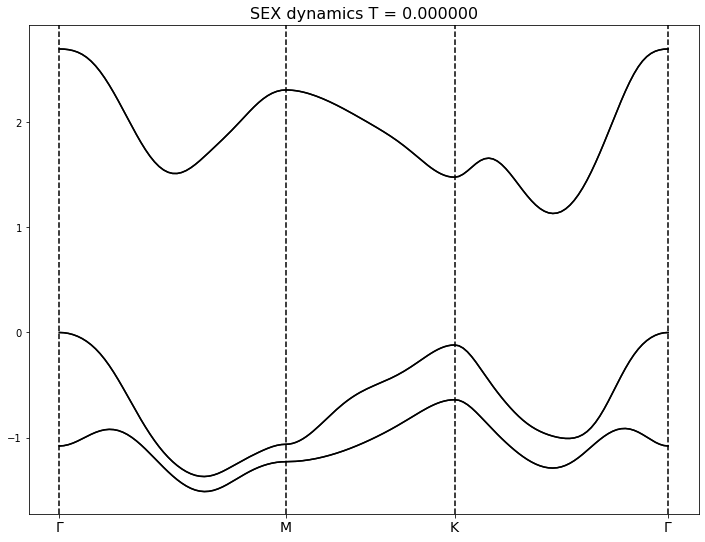

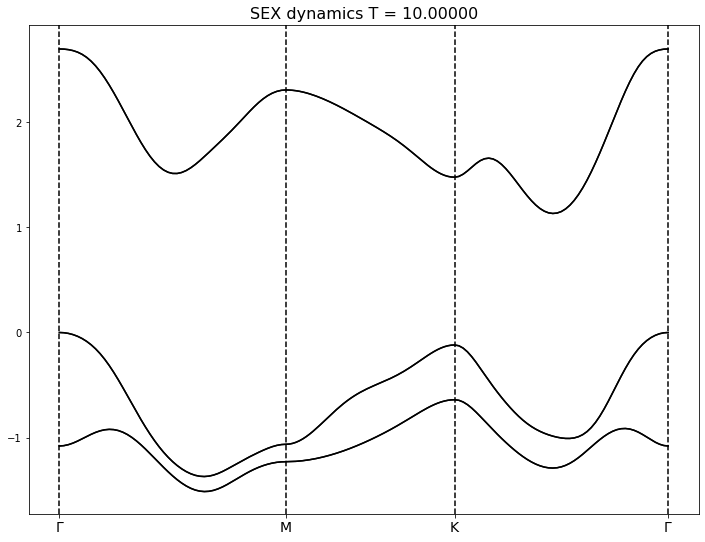

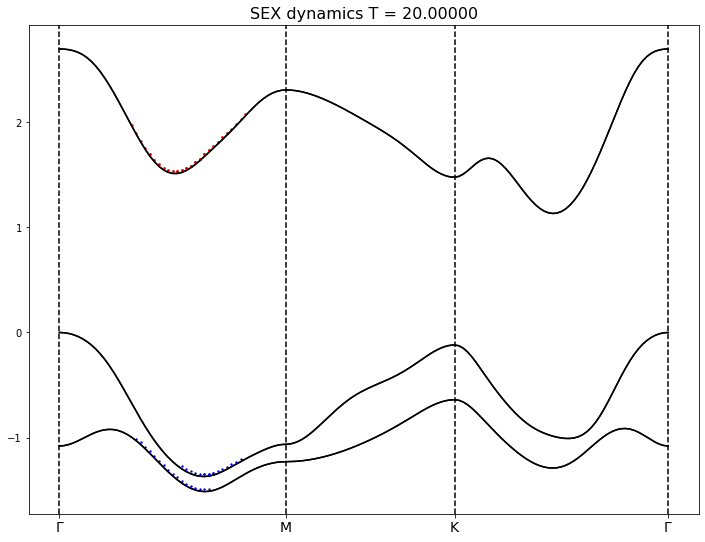

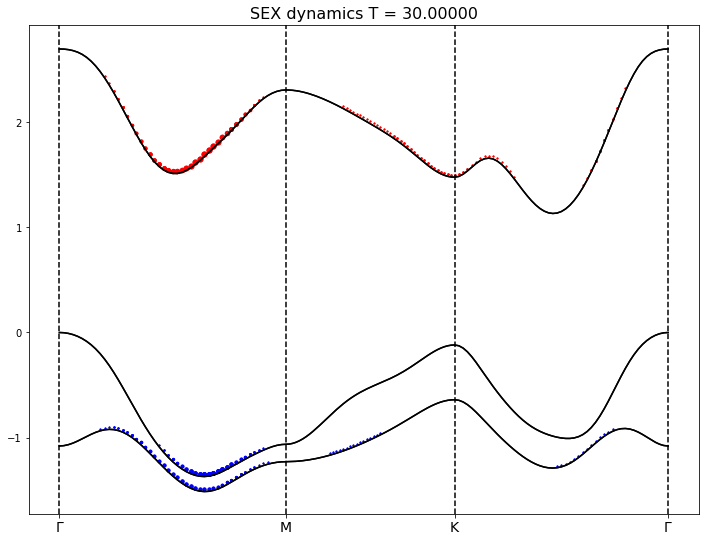

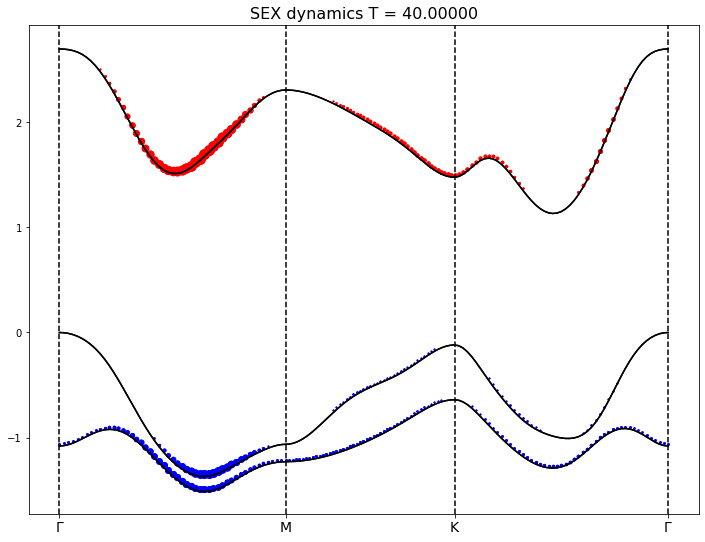

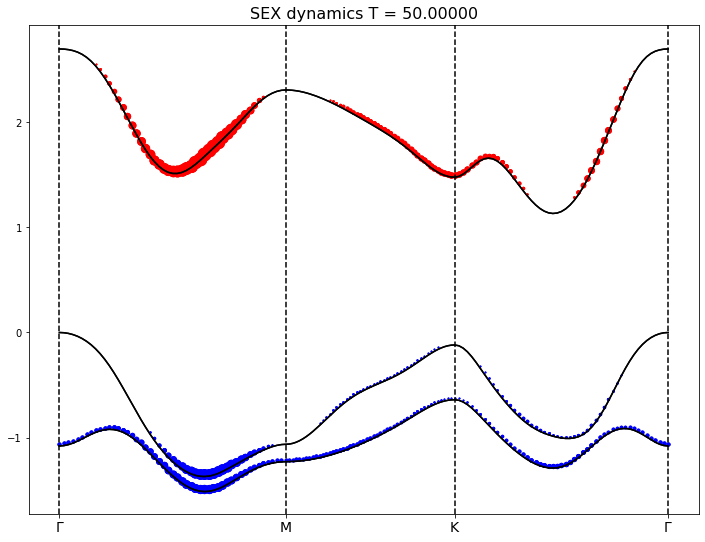

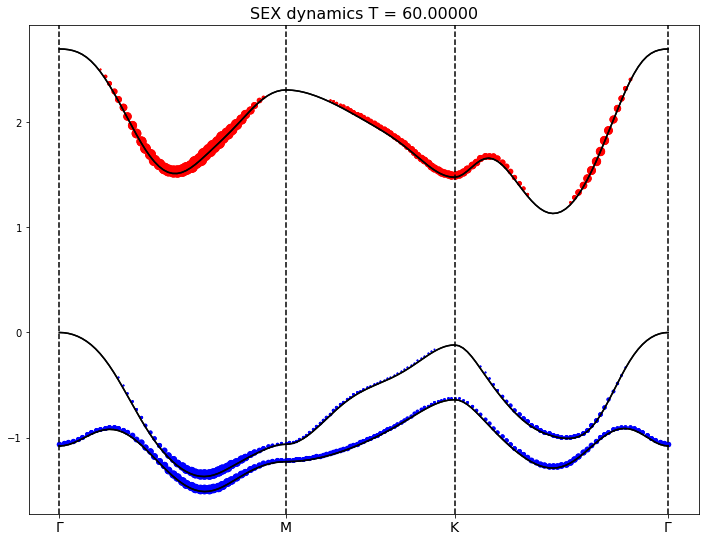

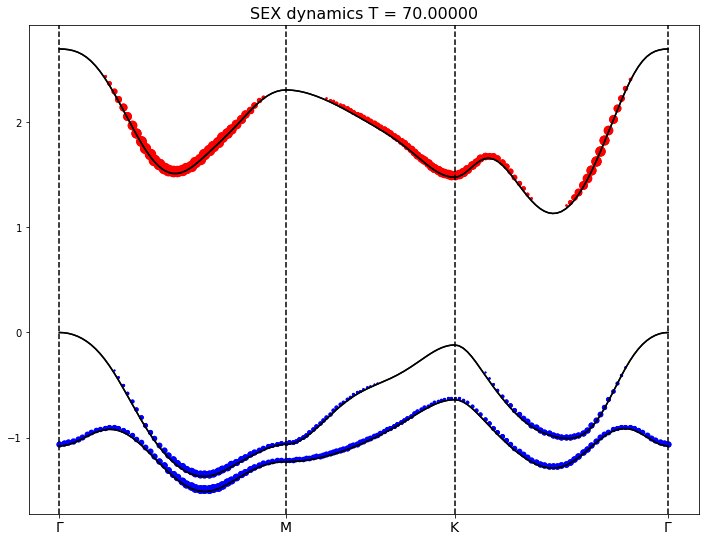

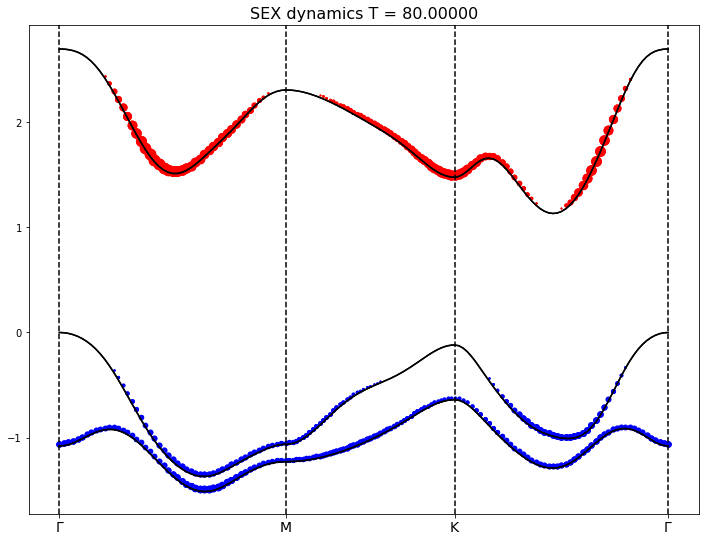

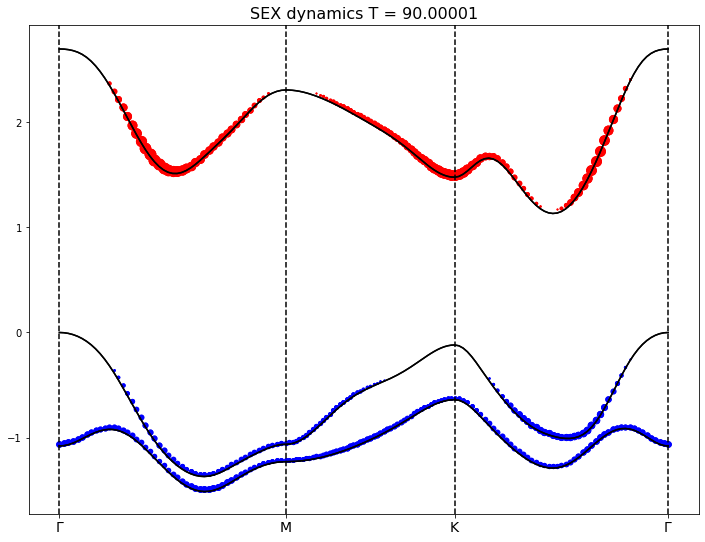

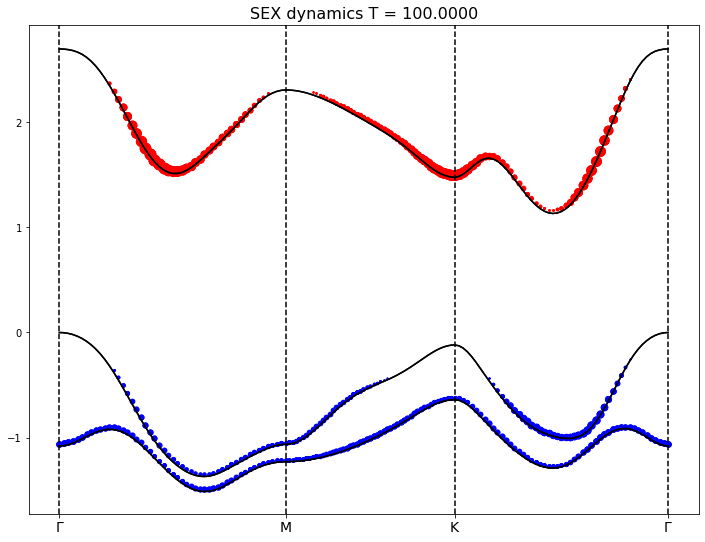

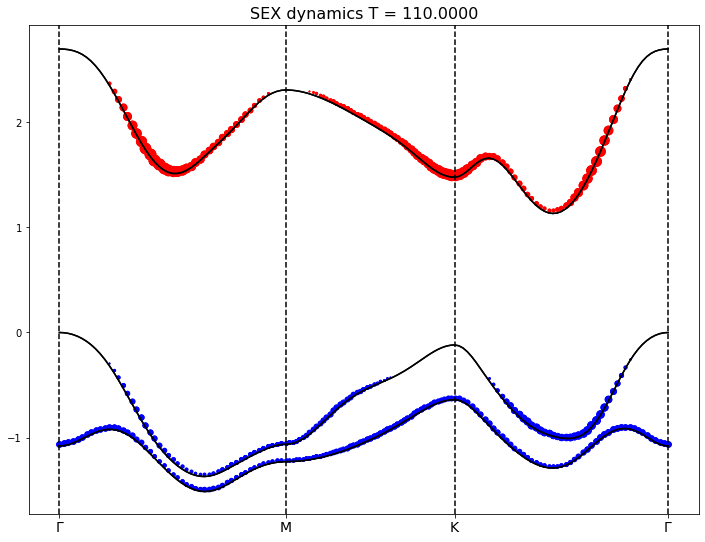

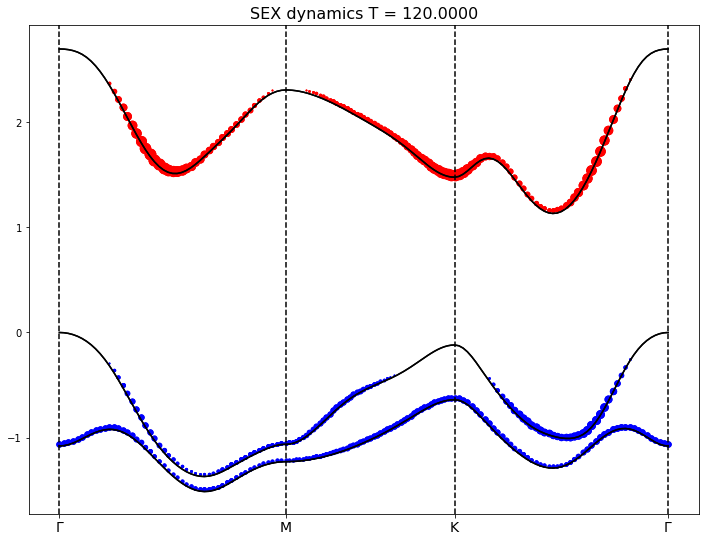

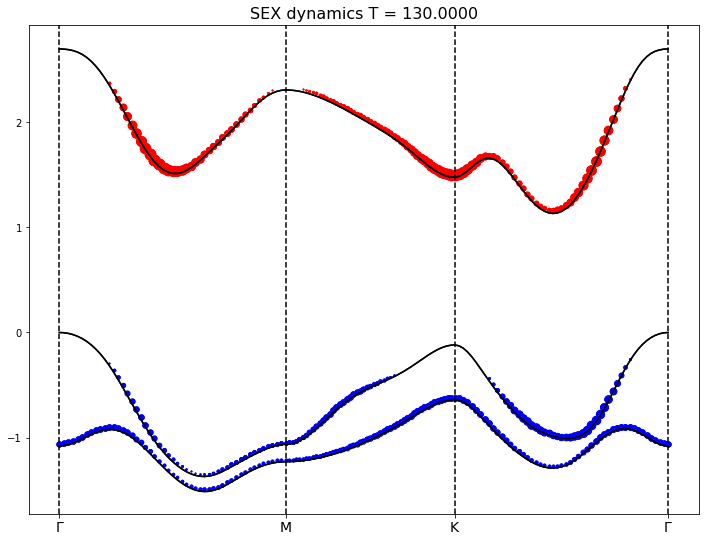

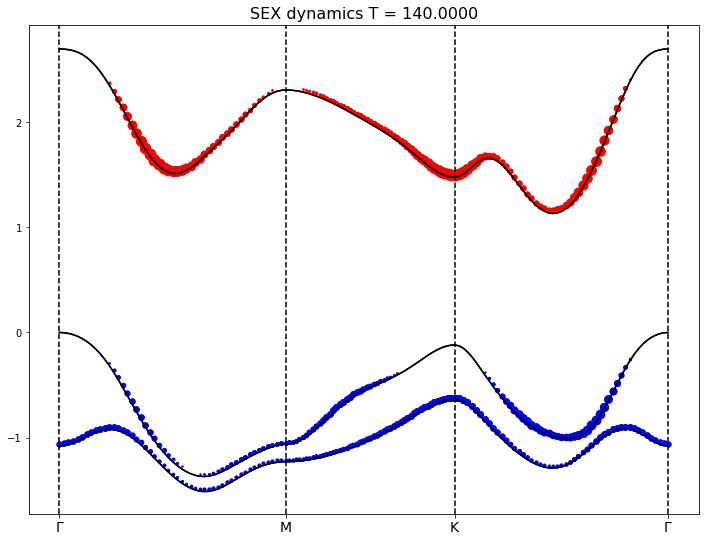

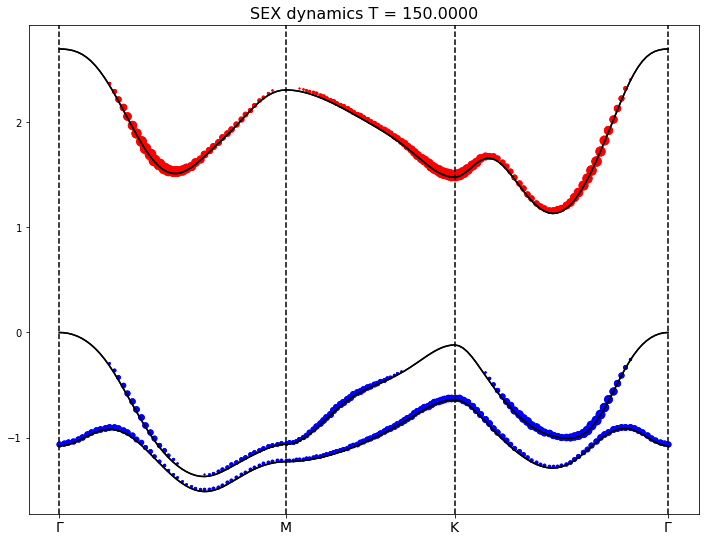

In [63]:
numBands = 6
shift = 0.6

kpath = ypp_bands.get_kpath()
for f in files:
    data = file_parser(os.path.join(sex_path,f))
    energy = np.array_split(data[1],numBands)
    occ = np.array_split(data[2],numBands)
    fig, ax = plt.subplots(figsize=(12, 9))
    ypp_bands.plot(plt,linestyle='-',c='black')

    for ind_b in range(numBands):
        for ind in range(len(kpath)):
            x,y,o = kpath[ind],energy[ind_b][ind],occ[ind_b][ind]
            if o < 0 : color = 'blue'
            if o >= 0 : color = 'red'
            plt.scatter(x,shift+y,s=abs(int(5e7*o)),c=color)
    plt.title('SEX dynamics T = %s'%f.split('_')[-1],size=16)
    plt.show()
    